# Starbucks Capstone Challenge Analysis

In [84]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2021-10-25 16:23:30 +08:00)


In [86]:
import pandas as pd
import numpy as np
import math
import json

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,KFold,cross_validate,cross_val_score
from sklearn import metrics
from sklearn.metrics import f1_score
import optuna

import matplotlib.pyplot as plt
import plotly.express as px

time: 0 ns (started: 2021-10-25 19:53:48 +08:00)


In [3]:
# load clean file
df=pd.read_csv('df_cleanR.csv',index_col="Unnamed: 0")
# load raw file
portfolio_clean = pd.read_csv('portfolio_clean.csv', index_col="Unnamed: 0")
profile_clean = pd.read_csv('profile_clean.csv', index_col="Unnamed: 0")
df_behavior = pd.read_csv('df_behavior.csv', index_col="Unnamed: 0")

time: 344 ms (started: 2021-10-25 15:33:15 +08:00)


In [4]:
df.head()

person                          offer_id  \
0  0009655768c64bdeb2e877511632db8f                                 0   
1  0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5   
2  0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   
3  0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
4  0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d   

   offer_count  receive_count  view_count  promo_time_last  promo_count  \
0          NaN            NaN         NaN              NaN          NaN   
1          1.0            NaN         NaN              NaN          NaN   
2          1.0            NaN         1.0              NaN          NaN   
3          1.0            NaN         1.0              NaN          NaN   
4          1.0            NaN         NaN              NaN          NaN   

   promo_amount_sum  buy_time_last  buy_count  ...     offer_type  \
0               NaN            NaN        NaN  ...            NaN   
1               NaN          576.0        1.0  ...       discount   
2               NaN            NaN        NaN  ...  informational   
3               NaN            NaN        NaN  ...  informational   
4               NaN          414.0        1.0  ...           bogo   

   channel_email  channel_mobile channel_social  channel_web  type_bogo  \
0            NaN             NaN            NaN          NaN        NaN   
1            1.0             1.0            0.0          1.0        0.0   
2            1.0             1.0            0.0          1.0        0.0   
3            1.0             1.0            1.0          0.0        0.0   
4            1.0             1.0            1.0          1.0        1.0   

   type_discount  type_informational  offer_code    return  
0            NaN                 NaN         NaN       NaN  
1            1.0                 0.0         aa5  0.199998  
2            0.0                 1.0         bed  0.000000  
3            0.0                 1.0         837  0.000000  
4            0.0                 0.0         20d  0.999980  

[5 rows x 39 columns]

time: 31 ms (started: 2021-10-25 15:33:16 +08:00)


In [5]:
# plotly config used to download higher resolution
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': None,
    'width': None,
    'scale': 2 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

time: 0 ns (started: 2021-10-25 15:33:16 +08:00)


# Overview

A normal procedure of promotion for customers is receive promotion,view promotion, and use promotion (transaction and complete).
So this procedure can be divided into two stage:
1. **View  stage**: Company send promotion info to target customers, and customers decide view it or not.This stage is about customer attributes and  offer channels.
2. **Engage stage**: After customers viewed the promotion, they decide whether to use the promotion or not. This stage is about customer attributes and offer attributes (not channels).

Depend on the different behaviors of certain promotion offer. Those behaviors can be classified into 5 parts.

1. **Success Promotion**: Finish two stage above. 
The transcript is start -> `offer receive`(1) -> `offer view`(2) ->`transaction`(3) -> `offer completed`(4) -> end.

2. **Direct Buy**: customer just buy regardless he or she just receive a promotion offer. 
The track record is start -> `offer receive`(1) -> `transaction`(3) -> `offer completed`(4) -> `offer view`(2) -> end .  offer view(2) can exist or not exist.

3. **Only View**: customer only finish stage 1.
start -> `offer receive`(1) -> `offer view`(2) -> end. 

4. **Only Receive**: customer just received an offer and didn't view or direct buy. 
start -> `offer receive`(1) -> end.

5. **Other Buy**: customer make other transaction not including any offer provided. start -> `transaction`(3)  -> end.


## Target Customers

During data clean process, I marked some NA age and incomes and filled them . To analyze target customers, I only choose Non-NA rows for more accuray.

In [6]:
profile_clean_nona = profile_clean[profile_clean['is_income_na']==0]

time: 16 ms (started: 2021-10-25 15:33:16 +08:00)


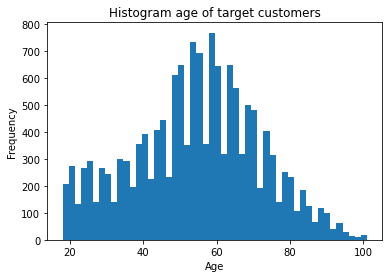

time: 203 ms (started: 2021-10-25 15:33:16 +08:00)


In [7]:
plt.hist(profile_clean_nona['age'],bins=50)
plt.title('Histogram age of target customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

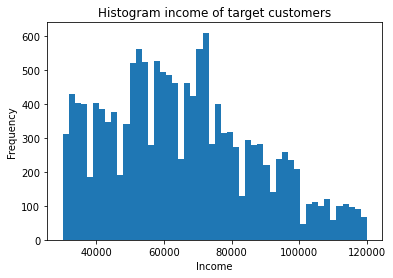

time: 156 ms (started: 2021-10-25 15:33:16 +08:00)


In [8]:
plt.hist(profile_clean_nona['income'],bins=50)
plt.title('Histogram income of target customers')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

<AxesSubplot:title={'center':'member_days_last distribution of target customers'}, ylabel='Frequency'>

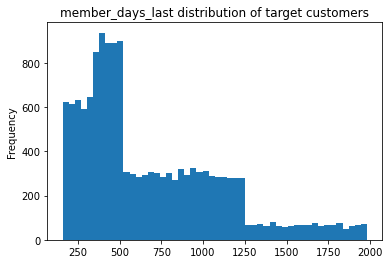

time: 188 ms (started: 2021-10-25 15:33:16 +08:00)


In [9]:
profile_clean_nona['member_days_last'].plot.hist(bins=50,title="member_days_last distribution of target customers")

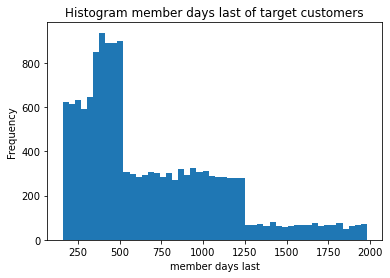

time: 141 ms (started: 2021-10-25 15:33:16 +08:00)


In [10]:
plt.hist(profile_clean_nona['member_days_last'],bins=50)
plt.title('Histogram member days last of target customers')
plt.xlabel('member days last')
plt.ylabel('Frequency')
plt.show()

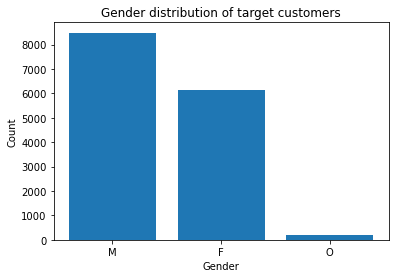

time: 110 ms (started: 2021-10-25 15:33:17 +08:00)


In [11]:
gender_dist = profile_clean_nona.gender.value_counts()
plt.bar(gender_dist.index,gender_dist)
plt.title('Gender distribution of target customers')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

## Promotion Type

Starbucks send 3 types of offer to make promotions. `Bogo` and `discount` are send 25k offers and `informational` send 12.6k.

In [12]:
portfolio_clean.sort_values(['offer_type','difficulty'])

reward  difficulty  duration     offer_type  \
3       5           5         7           bogo   
8       5           5         5           bogo   
0      10          10         7           bogo   
1      10          10         5           bogo   
5       3           7         7       discount   
6       2          10        10       discount   
9       2          10         7       discount   
4       5          20        10       discount   
2       0           0         4  informational   
7       0           0         3  informational   

                                 id  channel_email  channel_mobile  \
3  9b98b8c7a33c4b65b9aebfe6a799e6d9              1               1   
8  f19421c1d4aa40978ebb69ca19b0e20d              1               1   
0  ae264e3637204a6fb9bb56bc8210ddfd              1               1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0              1               1   
5  2298d6c36e964ae4a3e7e9706d1fb8c2              1               1   
6  fafdcd668e3743c1bb461111dcafc2a4              1               1   
9  2906b810c7d4411798c6938adc9daaa5              1               1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7              1               0   
2  3f207df678b143eea3cee63160fa8bed              1               1   
7  5a8bc65990b245e5a138643cd4eb9837              1               1   

   channel_social  channel_web  type_bogo  type_discount  type_informational  \
3               0            1          1              0                   0   
8               1            1          1              0                   0   
0               1            0          1              0                   0   
1               1            1          1              0                   0   
5               1            1          0              1                   0   
6               1            1          0              1                   0   
9               0            1          0              1                   0   
4               0            1          0              1                   0   
2               0            1          0              0                   1   
7               1            0          0              0                   1   

  offer_code    return  
3        6d9  0.999980  
8        20d  0.999980  
0        dfd  0.999990  
1        da0  0.999990  
5        8c2  0.428565  
6        2a4  0.199998  
9        aa5  0.199998  
4        1d7  0.249999  
2        bed  0.000000  
7        837  0.000000

time: 0 ns (started: 2021-10-25 15:33:17 +08:00)


In [13]:
type_df = df['offer_type'].value_counts()
type_df

bogo             25321
discount         25316
informational    12651
Name: offer_type, dtype: int64

time: 16 ms (started: 2021-10-25 15:33:17 +08:00)


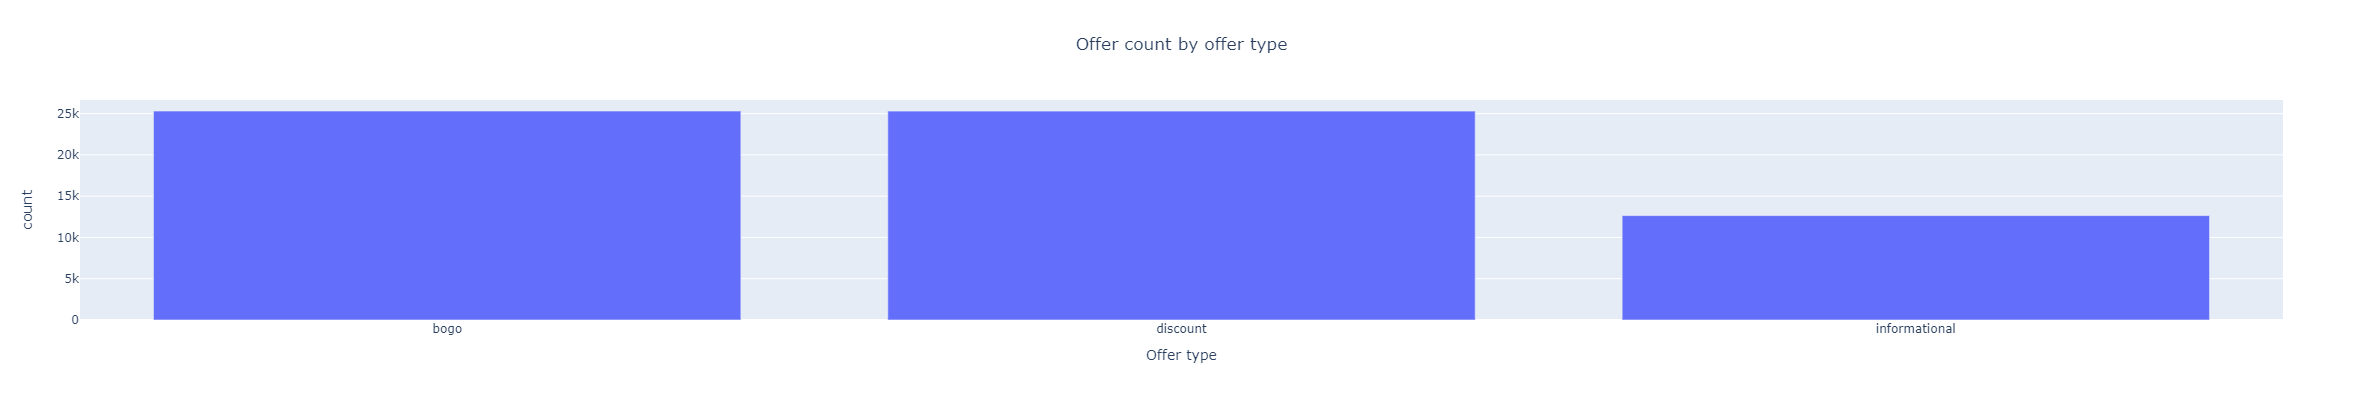

time: 687 ms (started: 2021-10-25 15:33:17 +08:00)


In [14]:
fig = px.bar(x=type_df.index, 
                 y=type_df,
                 labels={'x':'Offer type', 'y':'count'},
                 title="Offer count by offer type",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

However, not all the offers are viewed and engaged by customers. customers always have their own behavior.Let's see the overview map.

## Customer Response

In [15]:
# sum up all the behaviors by offer attributes
sum_df = df.groupby(['offer_type','difficulty','offer_code']).agg({'offer_count':np.sum,'receive_count':np.sum,'view_count':np.sum,'promo_count':np.sum,'buy_count':np.sum})

time: 15 ms (started: 2021-10-25 15:33:17 +08:00)


In [16]:
# add sum up rows
total_promo = sum_df.loc[['bogo','discount'],:].sum()
total_promo.name = ('Total_for_promotion','bogo+discount','bogo+discount')
total_info = sum_df.loc[['informational'],:].sum()
total_info.name = ('Total_for_informational','informational','informational')
total_all = sum_df.loc[['bogo','discount','informational'],:].sum()
total_all.name = ('All','all','all')

time: 0 ns (started: 2021-10-25 15:33:17 +08:00)


In [17]:
sum_df = sum_df.append(total_promo.transpose())
sum_df = sum_df.append(total_info.transpose())
sum_df = sum_df.append(total_all.transpose())

time: 0 ns (started: 2021-10-25 15:33:17 +08:00)


In [18]:
# add different behavior ratio
sum_df['only_receive_ratio']=sum_df['receive_count']/sum_df['offer_count']
sum_df['only_view_ratio']=sum_df['view_count']/sum_df['offer_count']
sum_df['success_promotion_ratio'] = sum_df['promo_count']/sum_df['offer_count']
sum_df['direct_buy_ratio']=sum_df['buy_count']/sum_df['offer_count']
sum_df['total_transaction_ratio']=(sum_df['buy_count']+sum_df['promo_count'])/sum_df['offer_count']
##
sum_df['view_receive_conversion']=(sum_df['view_count']+sum_df['promo_count'])/sum_df['offer_count']
sum_df['engage_view_conversion']=sum_df['promo_count']/(sum_df['view_count']+sum_df['promo_count'])


time: 0 ns (started: 2021-10-25 15:33:18 +08:00)


In [19]:
sum_df

offer_count  \
offer_type              difficulty    offer_code                   
bogo                    5.0           20d                 7571.0   
                                      6d9                 7677.0   
                        10.0          da0                 7593.0   
                                      dfd                 7658.0   
discount                7.0           8c2                 7646.0   
                        10.0          2a4                 7597.0   
                                      aa5                 7632.0   
                        20.0          1d7                 7668.0   
informational           0.0           837                 7618.0   
                                      bed                 7617.0   
Total_for_promotion     bogo+discount bogo+discount      61042.0   
Total_for_informational informational informational      15235.0   
All                     all           all                76277.0   

                                                     receive_count  \
offer_type              difficulty    offer_code                     
bogo                    5.0           20d                    181.0   
                                      6d9                   1916.0   
                        10.0          da0                    209.0   
                                      dfd                    515.0   
discount                7.0           8c2                    148.0   
                        10.0          2a4                    128.0   
                                      aa5                   2180.0   
                        20.0          1d7                   3172.0   
informational           0.0           837                    931.0   
                                      bed                   3473.0   
Total_for_promotion     bogo+discount bogo+discount         8449.0   
Total_for_informational informational informational         4404.0   
All                     all           all                  12853.0   

                                                     view_count  promo_count  \
offer_type              difficulty    offer_code                               
bogo                    5.0           20d                3094.0       3574.0   
                                      6d9                1407.0       2176.0   
                        10.0          da0                4053.0       2799.0   
                                      dfd                3455.0       2647.0   
discount                7.0           8c2                2342.0       4406.0   
                        10.0          2a4                2152.0       4676.0   
                                      aa5                1435.0       2160.0   
                        20.0          1d7                1076.0       1349.0   
informational           0.0           837                6687.0          0.0   
                                      bed                4144.0          0.0   
Total_for_promotion     bogo+discount bogo+discount     19014.0      23787.0   
Total_for_informational informational informational     10831.0          0.0   
All                     all           all               29845.0      23787.0   

                                                     buy_count  \
offer_type              difficulty    offer_code                 
bogo                    5.0           20d                722.0   
                                      6d9               2178.0   
                        10.0          da0                532.0   
                                      dfd               1041.0   
discount                7.0           8c2                750.0   
                        10.0          2a4                641.0   
                                      aa5               1857.0   
                        20.0          1d7               2071.0   
informational           0.0           837                  0.0   
                                      bed             

time: 16 ms (started: 2021-10-25 15:33:18 +08:00)


In [20]:
sum_df[['only_receive_ratio','only_view_ratio','success_promotion_ratio','direct_buy_ratio','total_transaction_ratio']]

only_receive_ratio  \
offer_type              difficulty    offer_code                          
bogo                    5.0           20d                      0.023907   
                                      6d9                      0.249577   
                        10.0          da0                      0.027525   
                                      dfd                      0.067250   
discount                7.0           8c2                      0.019357   
                        10.0          2a4                      0.016849   
                                      aa5                      0.285639   
                        20.0          1d7                      0.413667   
informational           0.0           837                      0.122211   
                                      bed                      0.455954   
Total_for_promotion     bogo+discount bogo+discount            0.138413   
Total_for_informational informational informational            0.289071   
All                     all           all                      0.168504   

                                                     only_view_ratio  \
offer_type              difficulty    offer_code                       
bogo                    5.0           20d                   0.408665   
                                      6d9                   0.183275   
                        10.0          da0                   0.533781   
                                      dfd                   0.451162   
discount                7.0           8c2                   0.306304   
                        10.0          2a4                   0.283270   
                                      aa5                   0.188024   
                        20.0          1d7                   0.140323   
informational           0.0           837                   0.877789   
                                      bed                   0.544046   
Total_for_promotion     bogo+discount bogo+discount         0.311490   
Total_for_informational informational informational         0.710929   
All                     all           all                   0.391271   

                                                     success_promotion_ratio  \
offer_type              difficulty    offer_code                               
bogo                    5.0           20d                           0.472064   
                                      6d9                           0.283444   
                        10.0          da0                           0.368629   
                                      dfd                           0.345652   
discount                7.0           8c2                           0.576249   
                        10.0          2a4                           0.615506   
                                      aa5                           0.283019   
                        20.0          1d7                           0.175926   
informational           0.0           837                           0.000000   
                                      bed                           0.000000   
Total_for_promotion     bogo+discount bogo+discount                 0.389683   
Total_for_informational informational informational                 0.000000   
All                     all           all                           0.311850   

                                                     direct_buy_ratio  \
offer_type              difficulty    offer_code                        
bogo                    5.0           20d                    0.095364   
                                      6d9                    0.283705   
                        10.0          da0                    0.070065   
                                      dfd                    0.135936   
discount                7.0           8c2                    0.098091   
                        10.0          2a4                    0.084375   
                                      aa5                    

time: 0 ns (started: 2021-10-25 15:33:18 +08:00)


In [21]:
sum_df[['offer_count','view_receive_conversion','engage_view_conversion']]

offer_count  \
offer_type              difficulty    offer_code                   
bogo                    5.0           20d                 7571.0   
                                      6d9                 7677.0   
                        10.0          da0                 7593.0   
                                      dfd                 7658.0   
discount                7.0           8c2                 7646.0   
                        10.0          2a4                 7597.0   
                                      aa5                 7632.0   
                        20.0          1d7                 7668.0   
informational           0.0           837                 7618.0   
                                      bed                 7617.0   
Total_for_promotion     bogo+discount bogo+discount      61042.0   
Total_for_informational informational informational      15235.0   
All                     all           all                76277.0   

                                                     view_receive_conversion  \
offer_type              difficulty    offer_code                               
bogo                    5.0           20d                           0.880729   
                                      6d9                           0.466719   
                        10.0          da0                           0.902410   
                                      dfd                           0.796814   
discount                7.0           8c2                           0.882553   
                        10.0          2a4                           0.898776   
                                      aa5                           0.471043   
                        20.0          1d7                           0.316249   
informational           0.0           837                           0.877789   
                                      bed                           0.544046   
Total_for_promotion     bogo+discount bogo+discount                 0.701173   
Total_for_informational informational informational                 0.710929   
All                     all           all                           0.703122   

                                                     engage_view_conversion  
offer_type              difficulty    offer_code                             
bogo                    5.0           20d                          0.535993  
                                      6d9                          0.607312  
                        10.0          da0                          0.408494  
                                      dfd                          0.433792  
discount                7.0           8c2                          0.652934  
                        10.0          2a4                          0.684827  
                                      aa5                          0.600834  
                        20.0          1d7                          0.556289  
informational           0.0           837                          0.000000  
                                      bed                          0.000000  
Total_for_promotion     bogo+discount bogo+discount                0.555758  
Total_for_informational informational informational                0.000000  
All                     all           all                          0.443523

time: 0 ns (started: 2021-10-25 15:33:18 +08:00)


Of all offers sent is 70% viewed by customers and the viewed are 55% completed in the end.

## Some Insights

1. **social channel is most important channel**

    If an offer use `social channel`, its `view_receive_conversion` would be higher than offers without `social channel`.

In [22]:
portfolio_clean['offer_code'] =  portfolio_clean['id'].map(lambda x:x[-3:])
channel_df = sum_df.iloc[0:-5,:].reset_index().merge(portfolio_clean[['channel_email','channel_mobile','channel_social','channel_web','offer_code']],left_on='offer_code',right_on='offer_code')
channel_df.index = sum_df.iloc[0:-5,:].index
channel_df

offer_type difficulty offer_code  \
offer_type difficulty offer_code                                    
bogo       5.0        20d              bogo        5.0        20d   
                      6d9              bogo        5.0        6d9   
           10.0       da0              bogo       10.0        da0   
                      dfd              bogo       10.0        dfd   
discount   7.0        8c2          discount        7.0        8c2   
           10.0       2a4          discount       10.0        2a4   
                      aa5          discount       10.0        aa5   
           20.0       1d7          discount       20.0        1d7   

                                  offer_count  receive_count  view_count  \
offer_type difficulty offer_code                                           
bogo       5.0        20d              7571.0          181.0      3094.0   
                      6d9              7677.0         1916.0      1407.0   
           10.0       da0              7593.0          209.0      4053.0   
                      dfd              7658.0          515.0      3455.0   
discount   7.0        8c2              7646.0          148.0      2342.0   
           10.0       2a4              7597.0          128.0      2152.0   
                      aa5              7632.0         2180.0      1435.0   
           20.0       1d7              7668.0         3172.0      1076.0   

                                  promo_count  buy_count  only_receive_ratio  \
offer_type difficulty offer_code                                               
bogo       5.0        20d              3574.0      722.0            0.023907   
                      6d9              2176.0     2178.0            0.249577   
           10.0       da0              2799.0      532.0            0.027525   
                      dfd              2647.0     1041.0            0.067250   
discount   7.0        8c2              4406.0      750.0            0.019357   
           10.0       2a4              4676.0      641.0            0.016849   
                      aa5              2160.0     1857.0            0.285639   
           20.0       1d7              1349.0     2071.0            0.413667   

                                  only_view_ratio  success_promotion_ratio  \
offer_type difficulty offer_code                                             
bogo       5.0        20d                0.408665                 0.472064   
                      6d9                0.183275                 0.283444   
           10.0       da0                0.533781                 0.368629   
                      dfd                0.451162                 0.345652   
discount   7.0        8c2                0.306304                 0.576249   
           10.0       2a4                0.283270                 0.615506   
                      aa5                0.188024                 0.283019   
           20.0       1d7                0.140323                 0.175926   

                                  direct_buy_ratio  total_transaction_ratio  \
offer_type difficulty offer_code                                              
bogo       5.0        20d                 0.095364                 0.567428   
                      6d9                 0.283705                 0.567149   
           10.0       da0                 0.070065                 0.438694   
                      dfd                 0.135936                 0.481588   
discount   7.0        8c2                 0.098091                 0.674340   
           10.0       2a4                 0.084375                 0.699882   
                      aa5                 0.243318                 0.526336   
           20.0       1d7                 0.270083                 0.446009   

                                  view_receive_conversion  \
offer_type difficulty offer_code                            
bogo       5.0        20d                        0.880729   
                      6d9

time: 32 ms (started: 2021-10-25 15:33:18 +08:00)


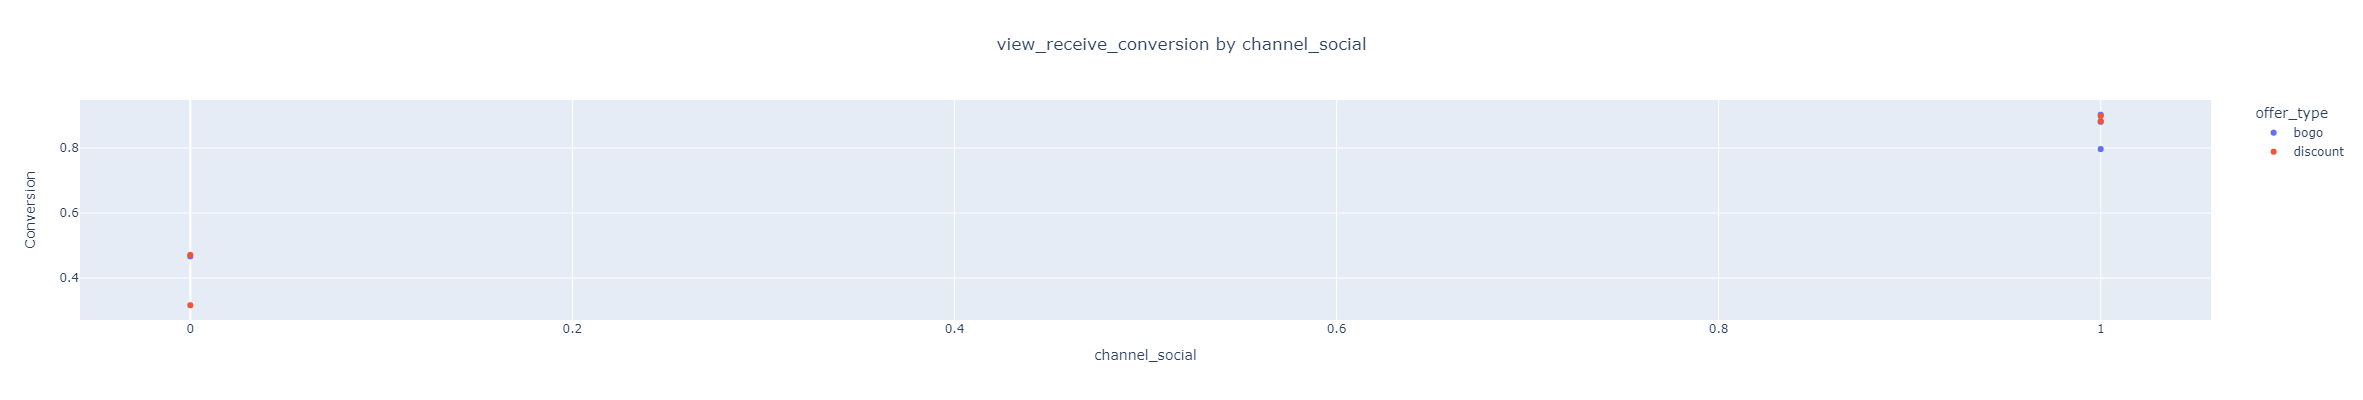

time: 63 ms (started: 2021-10-25 15:33:18 +08:00)


In [23]:
fig = px.scatter(channel_df,x="channel_social" ,
                 y="view_receive_conversion",
                 color = "offer_type",
                 labels={'x':'Income', 'view_receive_conversion':'Conversion'},
                 title="view_receive_conversion by channel_social",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

2. **Higher view_receive_conversion lead to lower direct buy ratio.**

   bogo(difficulty==5) and discount(difficulty==10) gives us a clear example. It seems there is a trade-off here.

In [24]:
view_buy_df = sum_df.iloc[0:-5,:][['view_receive_conversion','direct_buy_ratio']].reset_index()
view_buy_df

offer_type difficulty offer_code  view_receive_conversion  direct_buy_ratio
0       bogo        5.0        20d                 0.880729          0.095364
1       bogo        5.0        6d9                 0.466719          0.283705
2       bogo       10.0        da0                 0.902410          0.070065
3       bogo       10.0        dfd                 0.796814          0.135936
4   discount        7.0        8c2                 0.882553          0.098091
5   discount       10.0        2a4                 0.898776          0.084375
6   discount       10.0        aa5                 0.471043          0.243318
7   discount       20.0        1d7                 0.316249          0.270083

time: 0 ns (started: 2021-10-25 15:33:18 +08:00)


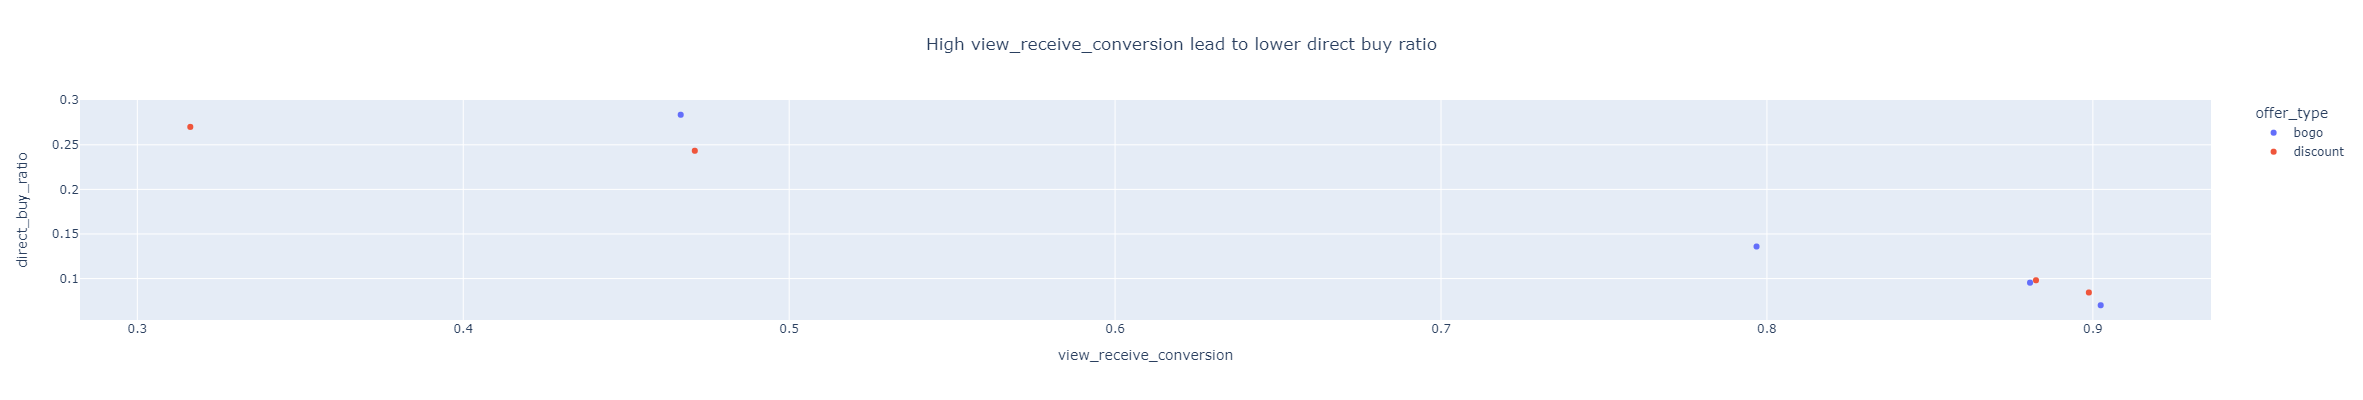

time: 47 ms (started: 2021-10-25 15:33:18 +08:00)


In [25]:
fig = px.scatter(view_buy_df,x="view_receive_conversion" ,
                 y="direct_buy_ratio",
                 color = "offer_type",
#                  labels={'x':'Income', 'view_receive_conversion':'Conversion'},
                 title="High view_receive_conversion lead to lower direct buy ratio",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show(config=config)

In [26]:
sum_df.loc[("bogo",5,slice(None)),['offer_count','view_receive_conversion','success_promotion_ratio','direct_buy_ratio']]

offer_count  view_receive_conversion  \
offer_type difficulty offer_code                                         
bogo       5.0        20d              7571.0                 0.880729   
                      6d9              7677.0                 0.466719   

                                  success_promotion_ratio  direct_buy_ratio  
offer_type difficulty offer_code                                             
bogo       5.0        20d                        0.472064          0.095364  
                      6d9                        0.283444          0.283705

time: 0 ns (started: 2021-10-25 15:33:18 +08:00)


In [27]:
sum_df.loc[("discount",10,slice(None)),['offer_count','view_receive_conversion','direct_buy_ratio']]

offer_count  view_receive_conversion  \
offer_type difficulty offer_code                                         
discount   10.0       2a4              7597.0                 0.898776   
                      aa5              7632.0                 0.471043   

                                  direct_buy_ratio  
offer_type difficulty offer_code                    
discount   10.0       2a4                 0.084375  
                      aa5                 0.243318

time: 0 ns (started: 2021-10-25 15:33:18 +08:00)


After a glimpse into overview, it's more important to see customer behavior in differe stage since it's constomer who response to a specific offer. If company can promote more accurayly, the more the company can get.

# View  Stage

This section intend to estimate which customer is likely to view an certain offer.

## Preprocessing

In [28]:
df_view_stage = df[df['offer_count']>=1]
df_view_stage = df_view_stage.fillna(0)
df_view_stage.shape

(63288, 39)

time: 32 ms (started: 2021-10-25 15:33:18 +08:00)


In [29]:
df_view_stage.loc[:,'view_behavior'] = df_view_stage['view_count']+df_view_stage['promo_count']

time: 0 ns (started: 2021-10-25 15:33:18 +08:00)


In [85]:
# if a customer has a view history, then this define a postive response here.
df_view_stage.loc[:,'target'] = df_view_stage['view_behavior'].map(lambda x:1 if x>=1 else 0)

time: 31 ms (started: 2021-10-25 18:21:49 +08:00)


## EDA

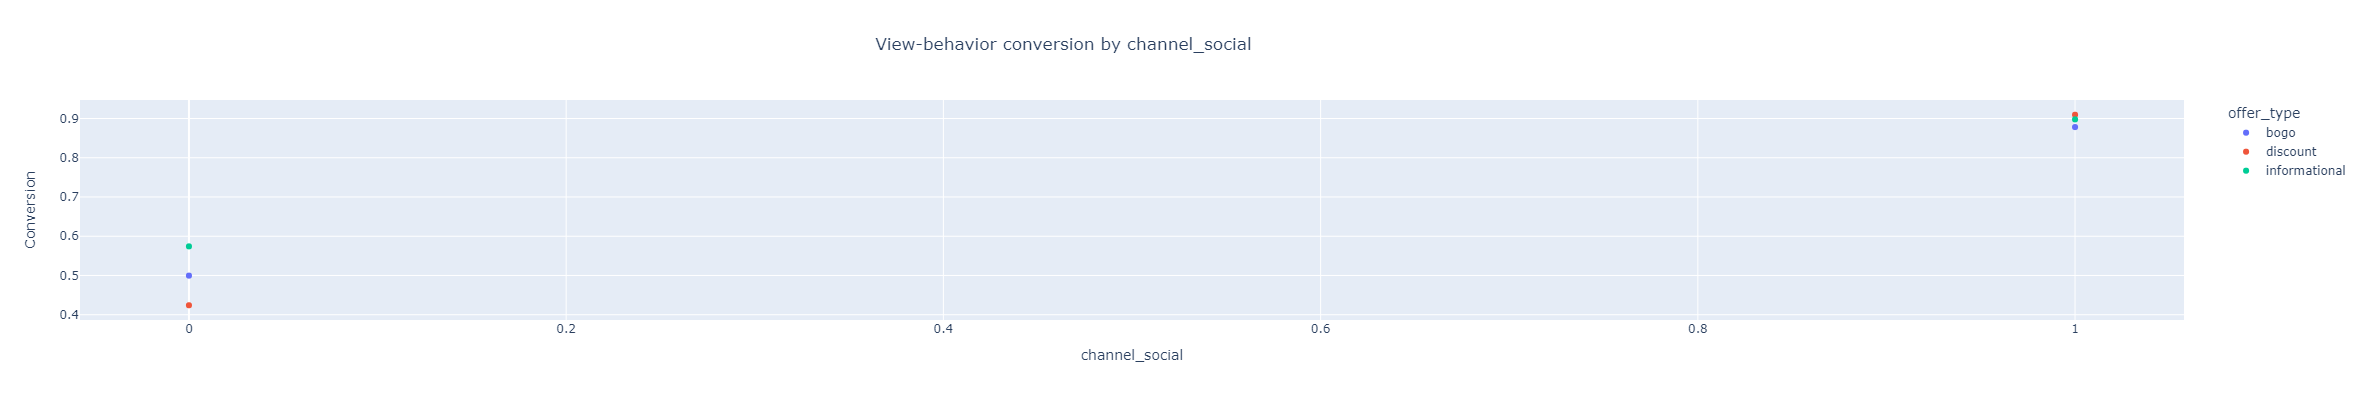

time: 63 ms (started: 2021-10-25 15:33:18 +08:00)


In [31]:
tmp = df_view_stage.groupby(['channel_social','offer_type']).agg({'target':np.mean}).reset_index()
fig = px.scatter(tmp,x="channel_social",
                 y="target",
                 color = "offer_type",
                 labels={'target':'Conversion'},
                 title="View-behavior conversion by channel_social",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.45)))
fig.show(config=config)

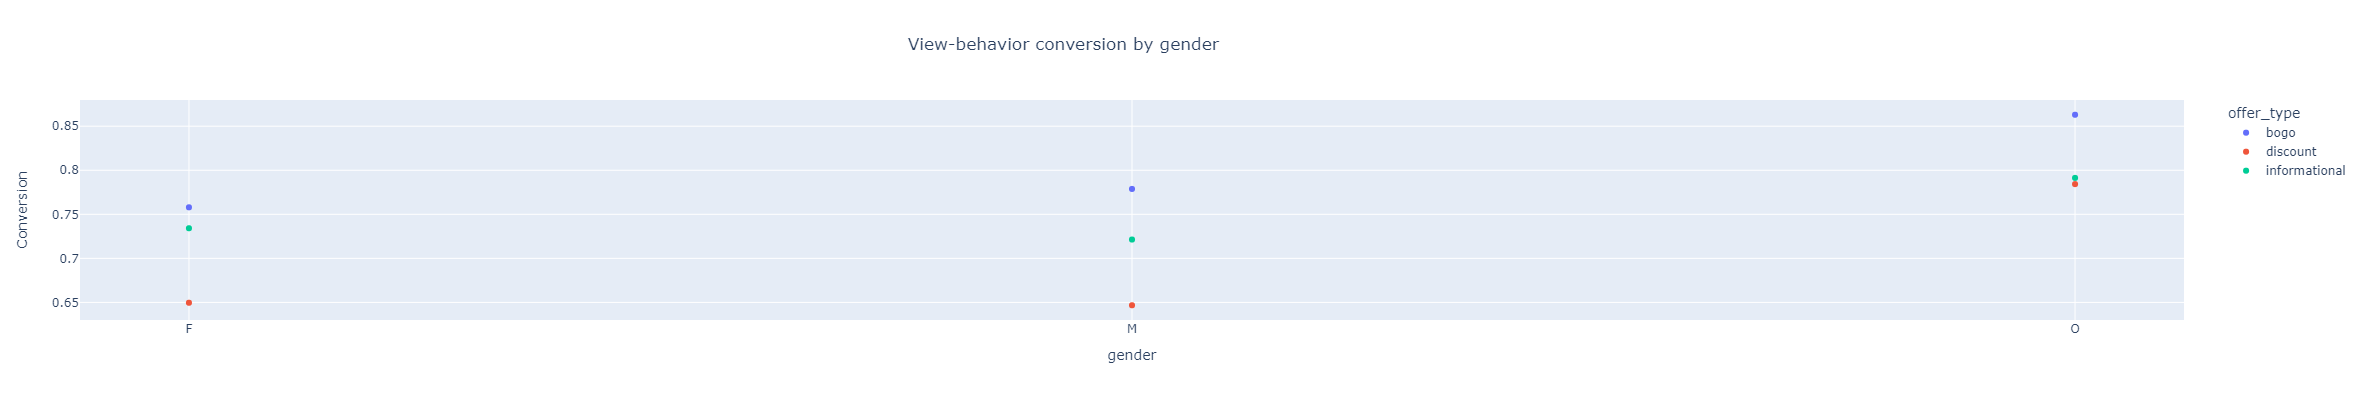

time: 63 ms (started: 2021-10-25 15:33:18 +08:00)


In [32]:
tmp = df_view_stage.groupby(['gender','offer_type']).agg({'target':np.mean}).reset_index()
fig = px.scatter(tmp,x="gender",
                 y="target",
                 color = "offer_type",
                 labels={'target':'Conversion'},
                 title="View-behavior conversion by gender",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.45)))
fig.show(config=config)

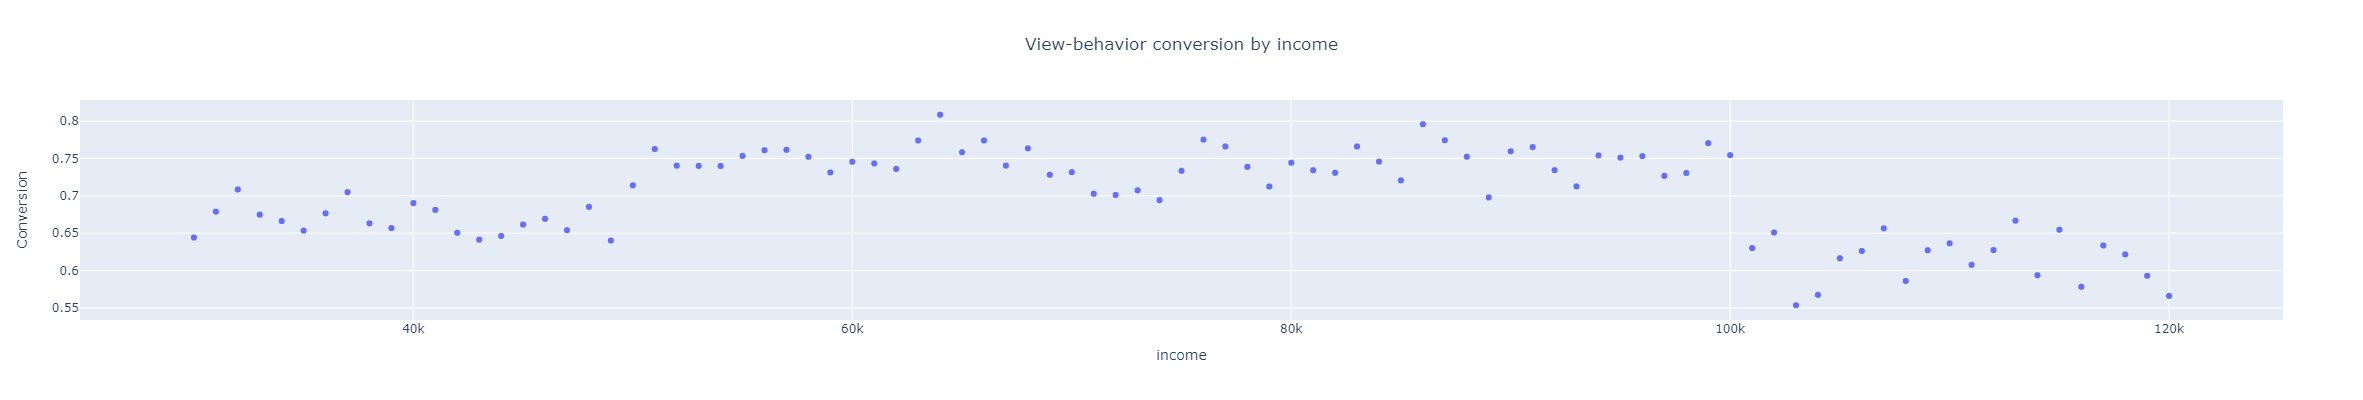

time: 47 ms (started: 2021-10-25 15:33:18 +08:00)


In [33]:
tmp = df_view_stage.groupby(['income']).agg({'target':np.mean}).reset_index()
fig = px.scatter(tmp,x="income",
                 y="target",
#                  color = "offer_type",
                 labels={'target':'Conversion'},
                 title="View-behavior conversion by income",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show(config=config)

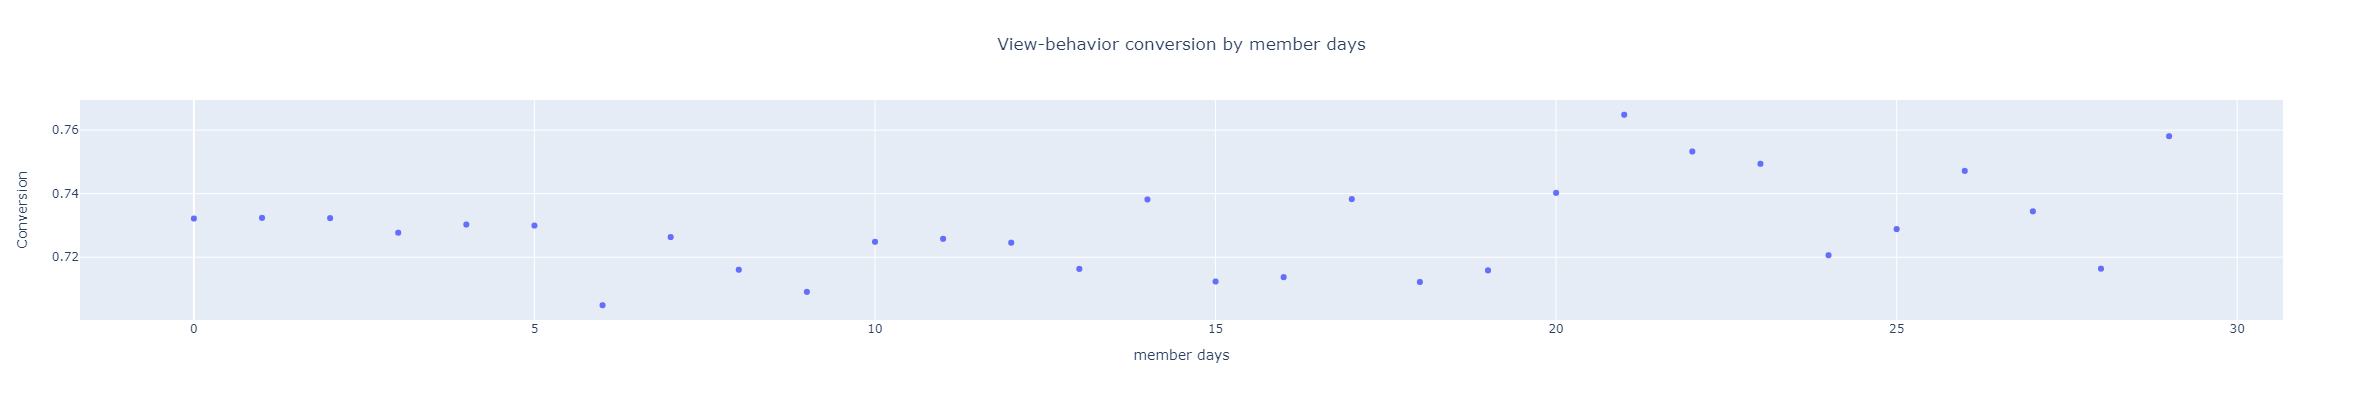

time: 47 ms (started: 2021-10-25 15:33:18 +08:00)


In [34]:
tmp = df_view_stage.groupby(['member_days_cut']).agg({'target':np.mean}).reset_index()
fig = px.scatter(tmp,x="member_days_cut",
                 y="target",
#                  color = "offer_type",
                 labels={'target':'Conversion','member_days_cut':'member days'},
                 title="View-behavior conversion by member days",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show(config=config)

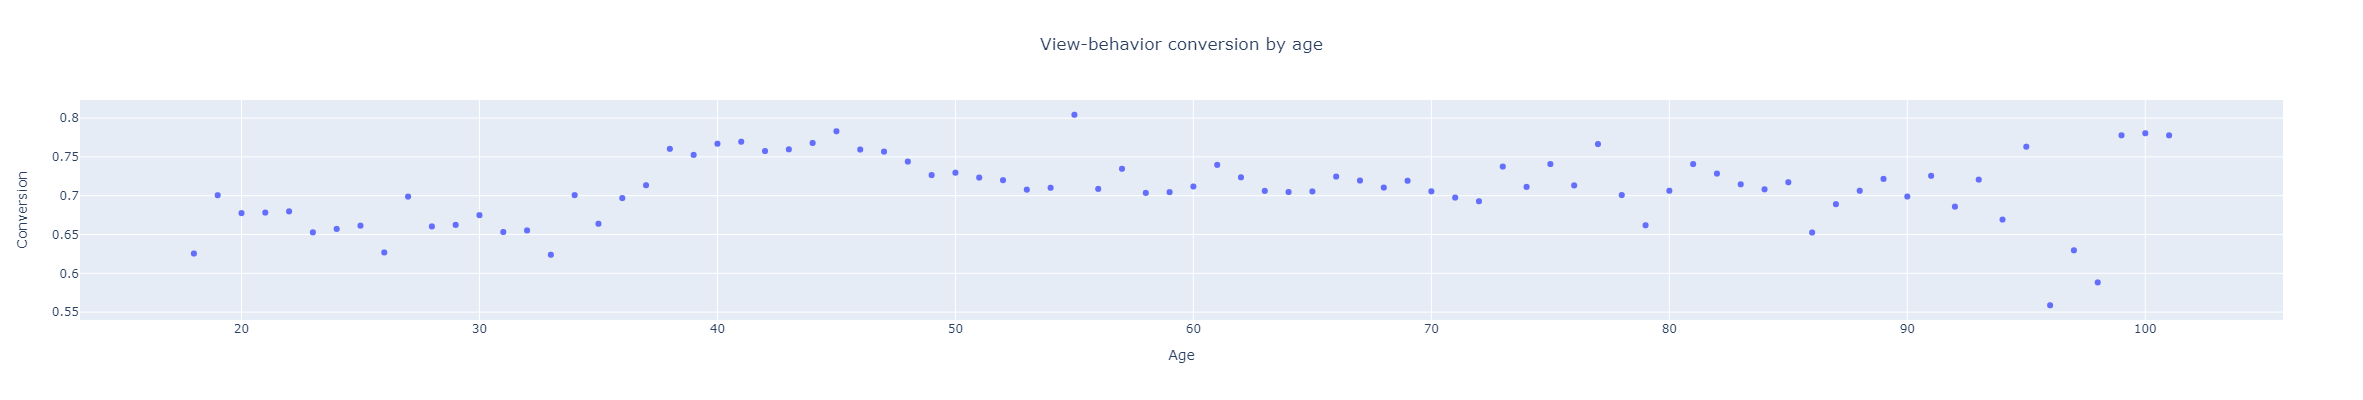

time: 47 ms (started: 2021-10-25 15:33:18 +08:00)


In [35]:
tmp = df_view_stage.groupby(['age']).agg({'target':np.mean}).reset_index()
fig = px.scatter(tmp,x="age",
                 y="target",
#                  color = "offer_type",
                 labels={'target':'Conversion','age':'Age'},
                 title="View-behavior conversion by age",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show(config=config)

Social channel is important to `view_behavior`. Male or female don't show a distinguished difference. And income can be split into 3 groups: [0,50000],[50000,100000],[100000+], [50000,100000] of income has the highest `view_behavior` chance.

## Model

I only choose channel attributes of offers, since customers wouldn't know offer type,difficulty,reward if they didn't view offers' infomation.

In [36]:
X_view_stage = df_view_stage[['age', 
        'member_in_year','member_in_month','member_on_day',
       'gender_F', 'gender_M', 'gender_O',
       'is_income_na', 'income', 
#         'reward', 'difficulty', 'duration','return',
       'channel_email', 'channel_mobile', 'channel_social', 'channel_web',
#        'type_bogo', 'type_discount','type_informational'
                  ]]

time: 31 ms (started: 2021-10-25 15:33:18 +08:00)


In [37]:
X_view_stage.shape

(63288, 13)

time: 0 ns (started: 2021-10-25 15:33:18 +08:00)


In [38]:
y_view_stage = df_view_stage['target']

time: 0 ns (started: 2021-10-25 15:33:18 +08:00)


In [39]:
y_view_stage.value_counts()

1    46020
0    17268
Name: target, dtype: int64

time: 0 ns (started: 2021-10-25 15:33:18 +08:00)


In [40]:
def predict_model(X: pd.DataFrame,y:pd.Series,metric:str)->pd.DataFrame:
    """use 7 algorithms to model data
    
    Args:
        X: pd.DataFrame,features
        y: pd.Series, target
        metric: sklearn metric to evaluate performance
    
    Returns:
        performance_df: A pd.DataFrame to state the performance of each algorithm
    """
    performance = []
    algorithms = [
        ('Logistic',LogisticRegression(random_state=1984,max_iter=1000)),
        ('RandomForest',RandomForestClassifier(random_state=1984)),
        ('LightGBM',LGBMClassifier(random_state=1984)),
        ('KNeighbors',KNeighborsClassifier()),
        ('ExtraTrees',ExtraTreesClassifier(random_state=1984,)),
        ('CatBoost',CatBoostClassifier(logging_level='Silent')),
        ('SVC',SVC(gamma='auto'))
    ]
    scaler=MinMaxScaler()
    X=scaler.fit_transform(X)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=1984)
    # estimate model performance
    for name,model in algorithms:
        kfold = KFold(n_splits=5)
        cv = cross_validate(model, X, y, cv=kfold,scoring=metric)
        score = np.average(cv['test_score'])
        score = round(score,4)
        performance.append({'model':name,metric:score})
    performance_df = pd.DataFrame.from_dict(performance)
    performance_df = performance_df.sort_values([metric],ascending=False)
    
    return performance_df
    

time: 0 ns (started: 2021-10-25 15:33:18 +08:00)


In [41]:
predict_model(X=X_view_stage,y=y_view_stage,metric='f1')

model      f1
2      LightGBM  0.8637
5      CatBoost  0.8634
6           SVC  0.8535
1  RandomForest  0.8528
4    ExtraTrees  0.8488
0      Logistic  0.8456
3    KNeighbors  0.8420

time: 6min 24s (started: 2021-10-25 15:33:18 +08:00)


The higher f1 score is 0.8640, the model would be good to estimate whether a customer will view a promotion offer.

## Model Tuning

In [42]:
def objective(trial:optuna.trial,X:pd.DataFrame,y:pd.Series,scoring:str)->float:
    """optimize objective fucntion of `optuna`
    Args:
        trial: optuna.trial
        X: pd.DataFrame,features
        y: pd.Series, target
        metric: sklearn metric to evaluate performance
    Retrun:
        accuracy: float,return the fit score after each trail of tuning.
    """
    x, y = X, y

    classifier_name = trial.suggest_categorical("classifier", [ "LightGBM","CatBoost","KNeighbors","Logistic","RandomForest"])
    if classifier_name == "Logistic":
        lr_c = trial.suggest_float("lr_c", 1e-10, 1e10, log=True)
        classifier_obj = LogisticRegression(
            C=lr_c,
        )
    elif classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = SVC(
            C=svc_c,
            gamma="auto"
        )
    elif classifier_name == "LightGBM":
        lg_max_depth = trial.suggest_int("lg_max_depth", 2, 100, log=True)
        lg_num_leaves = trial.suggest_int("lg_num_leaves", 2, 100, log=True)
        classifier_obj = LGBMClassifier(
            max_depth=lg_max_depth,
            num_leaves = lg_num_leaves
        )
    elif classifier_name == "CatBoost":
        ca_iterations = trial.suggest_int("iterations", 2, 100, log=True)
        classifier_obj = CatBoostClassifier(
            iterations=ca_iterations,
        )
    elif classifier_name == "KNeighbors":
        kn_n_neighbors = trial.suggest_int("kn_n_neighbors", 5, 100, log=True)
        classifier_obj = KNeighborsClassifier(
            n_neighbors=kn_n_neighbors
        )
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 5, 200, log=True)
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth, 
            n_estimators=rf_n_estimators
        )
    kfold = KFold(n_splits=5)
    score = cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=kfold,scoring=scoring)
    accuracy = score.mean()
    return accuracy

time: 0 ns (started: 2021-10-25 15:39:43 +08:00)


In [43]:
# tuning model with optuna
study_view_stage = optuna.create_study(direction="maximize")
study_view_stage.optimize(lambda trial:objective(trial,X_view_stage,y_view_stage,'f1'), n_trials=150)
print(study_view_stage.best_trial)

[I 2021-10-25 15:39:43,832] A new study created in memory with name: no-name-9b51e317-4e46-48a2-8a5f-75526e01bee9
[I 2021-10-25 15:39:45,729] Trial 0 finished with value: 0.842017554099589 and parameters: {'classifier': 'Logistic', 'lr_c': 2.0274827440150866e-09}. Best is trial 0 with value: 0.842017554099589.
[I 2021-10-25 15:39:48,093] Trial 1 finished with value: 0.8645262174175793 and parameters: {'classifier': 'CatBoost', 'iterations': 28}. Best is trial 1 with value: 0.8645262174175793.
[I 2021-10-25 15:39:52,463] Trial 2 finished with value: 0.8628015790387975 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 6, 'rf_n_estimators': 190}. Best is trial 1 with value: 0.8645262174175793.
[I 2021-10-25 15:39:53,569] Trial 3 finished with value: 0.8379448926562993 and parameters: {'classifier': 'KNeighbors', 'kn_n_neighbors': 25}. Best is trial 1 with value: 0.8645262174175793.
[I 2021-10-25 15:39:54,231] Trial 4 finished with value: 0.8411280453571098 and parameters: {'c

FrozenTrial(number=33, values=[0.8652323872619266], datetime_start=datetime.datetime(2021, 10, 25, 15, 40, 16, 542889), datetime_complete=datetime.datetime(2021, 10, 25, 15, 40, 17, 206439), params={'classifier': 'LightGBM', 'lg_max_depth': 5, 'lg_num_leaves': 46}, distributions={'classifier': CategoricalDistribution(choices=('LightGBM', 'CatBoost', 'KNeighbors', 'Logistic', 'RandomForest')), 'lg_max_depth': IntLogUniformDistribution(high=100, low=2, step=1), 'lg_num_leaves': IntLogUniformDistribution(high=100, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=33, state=TrialState.COMPLETE, value=None)
time: 1min 52s (started: 2021-10-25 15:39:43 +08:00)


The best performance `optuna` shows is `0.8652323872619266`, tiny improvement. And the params of that are `{'classifier': 'LightGBM', 'lg_max_depth': 5, 'lg_num_leaves': 46}`.

# Engage Stage

This section intend to estimate which customer with `view` behaviors is likely to complete an certain offer.

I choose `view_trans`>=1 which means I also filter the behavior without `view`. If a customer didn't view an offer, he or she should not finish the offer.

I choose offer type `bogo` and `discount` because they are only two offer which can reach a final completed record.

## Preprocessing

In [44]:
df_view_stage.shape

(63288, 41)

time: 16 ms (started: 2021-10-25 15:41:36 +08:00)


In [45]:
df_engage_stage=df_view_stage[df_view_stage['view_behavior']>=1]
df_engage_stage = df_engage_stage[df_engage_stage['offer_type'].isin(['bogo','discount'])]
df_engage_stage.shape

(36711, 41)

time: 32 ms (started: 2021-10-25 15:41:36 +08:00)


In [46]:
df_engage_stage.head()

person                          offer_id  \
7   00116118485d4dfda04fdbaba9a87b5c  f19421c1d4aa40978ebb69ca19b0e20d   
9   0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
10  0011e0d4e6b944f998e987f904e8c1e5  2298d6c36e964ae4a3e7e9706d1fb8c2   
13  0011e0d4e6b944f998e987f904e8c1e5  9b98b8c7a33c4b65b9aebfe6a799e6d9   
15  0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0   

    offer_count  receive_count  view_count  promo_time_last  promo_count  \
7           2.0            0.0         2.0              0.0          0.0   
9           1.0            0.0         0.0            576.0          1.0   
10          1.0            0.0         0.0            252.0          1.0   
13          1.0            0.0         0.0            576.0          1.0   
15          1.0            0.0         0.0            510.0          1.0   

    promo_amount_sum  buy_time_last  buy_count  ...  channel_mobile  \
7              0.000            0.0        0.0  ...             1.0   
9             11.025            0.0        0.0  ...             0.0   
10            11.930            0.0        0.0  ...             1.0   
13            11.025            0.0        0.0  ...             1.0   
15             8.620            0.0        0.0  ...             1.0   

    channel_social  channel_web type_bogo  type_discount  type_informational  \
7              1.0          1.0       1.0            0.0                 0.0   
9              0.0          1.0       0.0            1.0                 0.0   
10             1.0          1.0       0.0            1.0                 0.0   
13             0.0          1.0       1.0            0.0                 0.0   
15             1.0          1.0       1.0            0.0                 0.0   

    offer_code    return  view_behavior  target  
7          20d  0.999980            2.0       1  
9          1d7  0.249999            1.0       1  
10         8c2  0.428565            1.0       1  
13         6d9  0.999980            1.0       1  
15         da0  0.999990            1.0       1  

[5 rows x 41 columns]

time: 31 ms (started: 2021-10-25 15:41:36 +08:00)


In [47]:
# if a customer has a  view history, then this define a postive response here.
df_engage_stage.loc[:,'target'] = df_engage_stage['promo_count'].map(lambda x:1 if x>=1 else 0)

time: 16 ms (started: 2021-10-25 15:41:36 +08:00)


In [48]:
df_engage_stage.groupby(['offer_id']).agg({'target':['count','sum'],'promo_count':['count','sum']})

target       promo_count        
                                  count   sum       count     sum
offer_id                                                         
0b1e1539f2cc45b7b9fa7c272da2e1d7   2197  1249        2197  1349.0
2298d6c36e964ae4a3e7e9706d1fb8c2   5703  3883        5703  4406.0
2906b810c7d4411798c6938adc9daaa5   3172  1960        3172  2160.0
4d5c57ea9a6940dd891ad53e9dbe8da0   5792  2474        5792  2799.0
9b98b8c7a33c4b65b9aebfe6a799e6d9   3175  2001        3175  2176.0
ae264e3637204a6fb9bb56bc8210ddfd   5241  2371        5241  2647.0
f19421c1d4aa40978ebb69ca19b0e20d   5622  3190        5622  3574.0
fafdcd668e3743c1bb461111dcafc2a4   5809  4084        5809  4676.0

time: 15 ms (started: 2021-10-25 15:41:36 +08:00)


## EDA

In [49]:
columnx = ['offer_count','age','member_days_last','member_days_cut', 'member_in_year', 'gender',
        'income','income_cut']

time: 0 ns (started: 2021-10-25 15:41:36 +08:00)


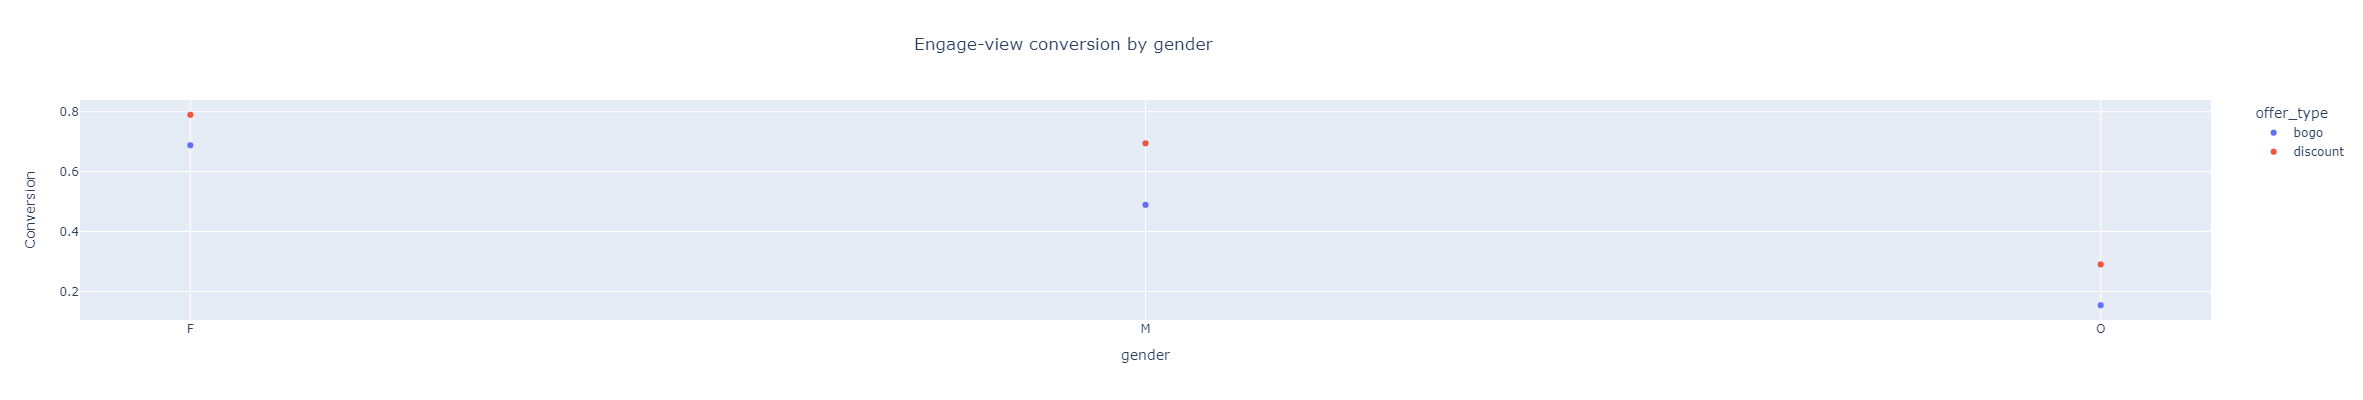

time: 62 ms (started: 2021-10-25 15:41:36 +08:00)


In [50]:
tmp = df_engage_stage.groupby(['gender','offer_type']).agg({'target':np.mean}).reset_index()
fig = px.scatter(tmp,x="gender",
                 y="target",
                 color = "offer_type",
                 labels={'target':'Conversion'},
                 title="Engage-view conversion by gender",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.45)))
fig.show(config=config)

The female have higher engage-view conversion than the male.

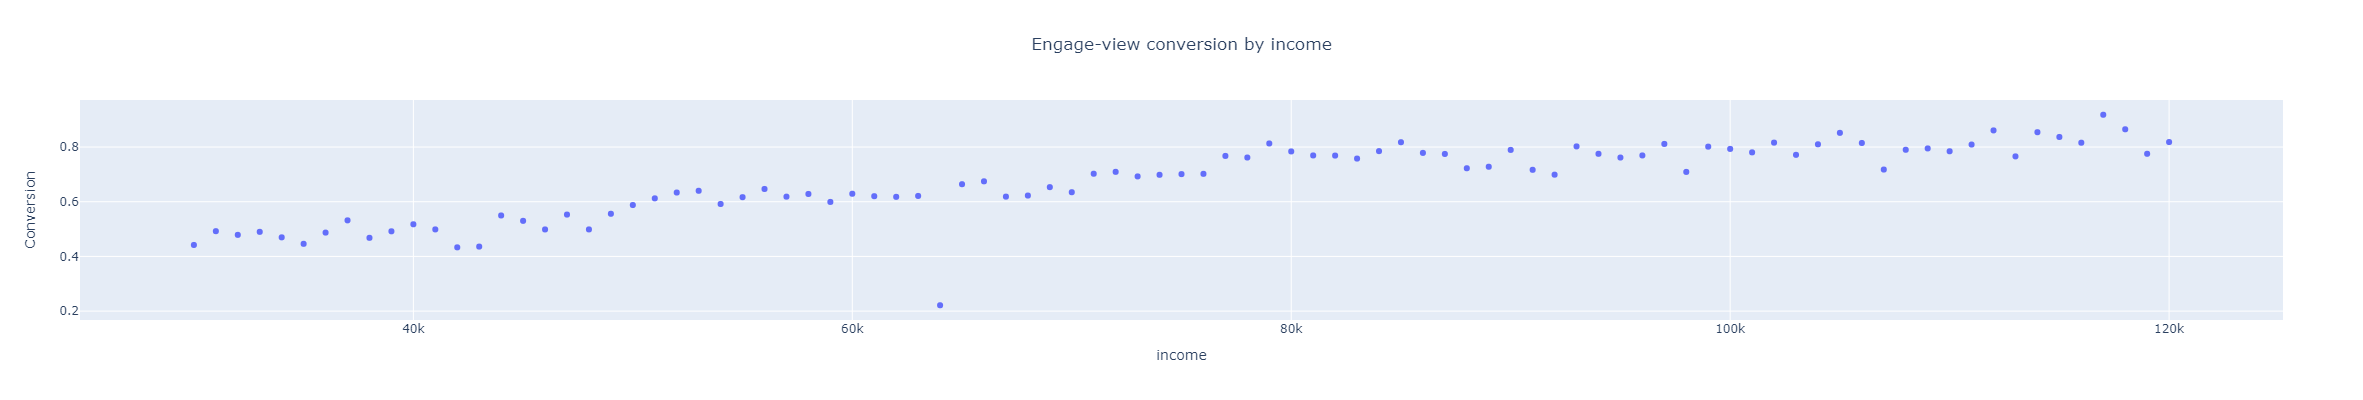

time: 47 ms (started: 2021-10-25 15:41:36 +08:00)


In [51]:
tmp = df_engage_stage.groupby(['income']).agg({'target':np.mean}).reset_index()
fig = px.scatter(tmp,x="income",
                 y="target",
#                  color = "offer_type",
                 labels={'target':'Conversion'},
                 title="Engage-view conversion by income",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show(config=config)

Higher income leads to higher engage-view ratio.

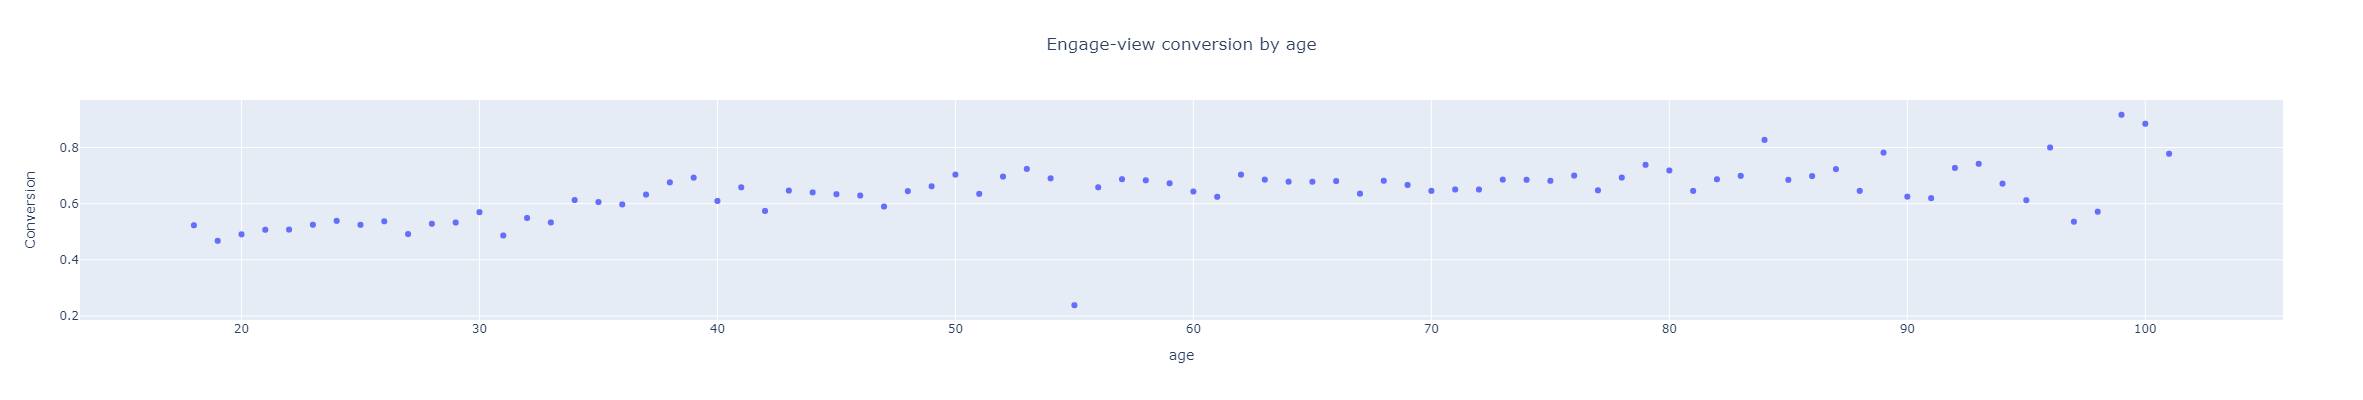

time: 46 ms (started: 2021-10-25 15:41:36 +08:00)


In [52]:
tmp = df_engage_stage.groupby(['age']).agg({'target':np.mean}).reset_index()
fig = px.scatter(tmp,x="age",
                 y="target",
#                  color = "offer_type",
                 labels={'target':'Conversion'},
                 title="Engage-view conversion by age",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show(config=config)

Higher age between 20 to 80 lead to higher engage-view ratio.

## Model

Attributes other than channels of offers are chosen, because customers should not consider where the source of offer. Whether to response to an offer is about the consumer himself and the offer attributes involving with deals.

In [53]:
X_engage_stage = df_engage_stage[['age', 
        'member_in_year','member_in_month','member_on_day',
       'gender_F', 'gender_M', 'gender_O',
       'is_income_na', 'income', 
        'reward', 'difficulty', 'duration','return',
#        'channel_email', 'channel_mobile', 'channel_social', 'channel_web',
       'type_bogo', 'type_discount','type_informational']]

time: 0 ns (started: 2021-10-25 15:41:36 +08:00)


In [54]:
X_engage_stage.shape

(36711, 16)

time: 0 ns (started: 2021-10-25 15:41:36 +08:00)


In [55]:
y_engage_stage = df_engage_stage['target']

time: 0 ns (started: 2021-10-25 15:41:37 +08:00)


In [56]:
y_engage_stage.value_counts()

1    21212
0    15499
Name: target, dtype: int64

time: 0 ns (started: 2021-10-25 15:41:37 +08:00)


In [57]:
predict_model(X=X_engage_stage,y=y_engage_stage,metric='f1')

model      f1
2      LightGBM  0.7861
6           SVC  0.7856
5      CatBoost  0.7850
0      Logistic  0.7755
4    ExtraTrees  0.7696
1  RandomForest  0.7694
3    KNeighbors  0.7603

time: 2min 54s (started: 2021-10-25 15:41:37 +08:00)


The higher f1 score is 0.79, the model would be good to estimate whether a customer will engage a promotion offer.

## Model Tuning

In [58]:
# tuning model with optuna
study_engage_stage = optuna.create_study(direction="maximize")
study_engage_stage.optimize(lambda trial:objective(trial,X_engage_stage,y_engage_stage,'f1'), n_trials=150)
print(study_engage_stage.best_trial)

[I 2021-10-25 15:44:31,345] A new study created in memory with name: no-name-8d19ea5e-7532-4786-a679-c663b08cf9c0
[I 2021-10-25 15:44:31,850] Trial 0 finished with value: 0.7887386402696852 and parameters: {'classifier': 'CatBoost', 'iterations': 20}. Best is trial 0 with value: 0.7887386402696852.
[I 2021-10-25 15:44:32,353] Trial 1 finished with value: 0.7885220285732905 and parameters: {'classifier': 'CatBoost', 'iterations': 22}. Best is trial 0 with value: 0.7887386402696852.
[I 2021-10-25 15:44:33,820] Trial 2 finished with value: 0.7896074604205462 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 9, 'rf_n_estimators': 92}. Best is trial 2 with value: 0.7896074604205462.
[I 2021-10-25 15:44:34,573] Trial 3 finished with value: 0.7467737684528142 and parameters: {'classifier': 'KNeighbors', 'kn_n_neighbors': 19}. Best is trial 2 with value: 0.7896074604205462.
[I 2021-10-25 15:44:34,931] Trial 4 finished with value: 0.7498194968665663 and parameters: {'classifier': '

FrozenTrial(number=62, values=[0.7915619665476848], datetime_start=datetime.datetime(2021, 10, 25, 15, 46, 12, 297660), datetime_complete=datetime.datetime(2021, 10, 25, 15, 46, 14, 791757), params={'classifier': 'RandomForest', 'rf_max_depth': 10, 'rf_n_estimators': 140}, distributions={'classifier': CategoricalDistribution(choices=('LightGBM', 'CatBoost', 'KNeighbors', 'Logistic', 'RandomForest')), 'rf_max_depth': IntLogUniformDistribution(high=32, low=2, step=1), 'rf_n_estimators': IntLogUniformDistribution(high=200, low=5, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=62, state=TrialState.COMPLETE, value=None)
time: 5min 21s (started: 2021-10-25 15:44:31 +08:00)


The best performance `optuna` shows is0.7915619665476848, a small improvement. And the params of that are `{'classifier': 'RandomForest', 'rf_max_depth': 10, 'rf_n_estimators': 140},`.

# Direct Buy

Now there are some customers who just buy the promoted goods without viewing the offer or just viewing it after the deal. We can conclude these customers didn't spend much time on promotion informations.

So if we want to etimate whether a customer will direct buy a coffee, we can only use attributes of person not those  of an offer like reward, diffculty etc.

## Preprocessing

Choose attributes of customers and filter rows with NA income.

In [59]:
df_buy = df[(df['is_income_na']==0)&(df['offer_type'].isin(['bogo','discount']))]

time: 32 ms (started: 2021-10-25 15:49:52 +08:00)


In [60]:
df_buy_model = df_buy.groupby(['person']).agg({'buy_count':'sum','offer_count':'sum'})
df_buy_model.shape

(14764, 2)

time: 0 ns (started: 2021-10-25 15:49:52 +08:00)


In [61]:
df_buy_model = df_buy_model.merge(df_buy[['person','age', 'member_days_last', 'member_in_year','member_in_month', 'member_on_day','gender', 'gender_F', 'gender_M', 'gender_O','is_income_na', 'income','income_cut','member_days_cut']],left_on='person',right_on='person',how='left')
df_buy_model = df_buy_model.drop_duplicates()
df_buy_model.shape

(14764, 16)

time: 63 ms (started: 2021-10-25 15:49:52 +08:00)


In [62]:
df_buy_model.head()

person  buy_count  offer_count   age  \
0   0009655768c64bdeb2e877511632db8f        3.0          3.0  33.0   
3   0011e0d4e6b944f998e987f904e8c1e5        0.0          3.0  40.0   
6   0020c2b971eb4e9188eac86d93036a77        1.0          4.0  59.0   
9   0020ccbbb6d84e358d3414a3ff76cffd        0.0          3.0  24.0   
12  003d66b6608740288d6cc97a6903f4f0        1.0          3.0  26.0   

    member_days_last  member_in_year  member_in_month  member_on_day gender  \
0                619            2017                4             21      M   
3                356            2018                1              9      O   
6               1032            2016                3              4      F   
9                780            2016               11             11      F   
12               558            2017                6             21      F   

    gender_F  gender_M  gender_O  is_income_na   income  income_cut  \
0          0         1         0             0  72000.0          13   
3          0         0         1             0  57000.0           8   
6          1         0         0             0  90000.0          19   
9          1         0         0             0  60000.0           9   
12         1         0         0             0  73000.0          14   

    member_days_cut  
0                 7  
3                 3  
6                14  
9                10  
12                6

time: 0 ns (started: 2021-10-25 15:49:52 +08:00)


In [63]:
df_buy_model.groupby(['person']).agg({'buy_count':'sum'}).buy_count.value_counts()

0.0    8221
1.0    4216
2.0    1683
3.0     538
4.0      95
5.0      10
6.0       1
Name: buy_count, dtype: int64

time: 16 ms (started: 2021-10-25 15:49:52 +08:00)


In [64]:
# if a customer has a direct-buy history, then this define a postive response here.
df_buy_model.loc[:,'target'] = df_buy_model['buy_count'].map(lambda x:1 if x>0 else 0)

time: 0 ns (started: 2021-10-25 15:49:52 +08:00)


In [65]:
df_buy_model.shape

(14764, 17)

time: 16 ms (started: 2021-10-25 15:49:52 +08:00)


In [66]:
df_buy_model.head()

person  buy_count  offer_count   age  \
0   0009655768c64bdeb2e877511632db8f        3.0          3.0  33.0   
3   0011e0d4e6b944f998e987f904e8c1e5        0.0          3.0  40.0   
6   0020c2b971eb4e9188eac86d93036a77        1.0          4.0  59.0   
9   0020ccbbb6d84e358d3414a3ff76cffd        0.0          3.0  24.0   
12  003d66b6608740288d6cc97a6903f4f0        1.0          3.0  26.0   

    member_days_last  member_in_year  member_in_month  member_on_day gender  \
0                619            2017                4             21      M   
3                356            2018                1              9      O   
6               1032            2016                3              4      F   
9                780            2016               11             11      F   
12               558            2017                6             21      F   

    gender_F  gender_M  gender_O  is_income_na   income  income_cut  \
0          0         1         0             0  72000.0          13   
3          0         0         1             0  57000.0           8   
6          1         0         0             0  90000.0          19   
9          1         0         0             0  60000.0           9   
12         1         0         0             0  73000.0          14   

    member_days_cut  target  
0                 7       1  
3                 3       0  
6                14       1  
9                10       0  
12                6       1

time: 0 ns (started: 2021-10-25 15:49:52 +08:00)


## EDA

In [67]:
columnx = ['offer_count','age','member_days_last','member_days_cut', 'member_in_year', 'gender',
        'income','income_cut']

time: 0 ns (started: 2021-10-25 15:49:52 +08:00)


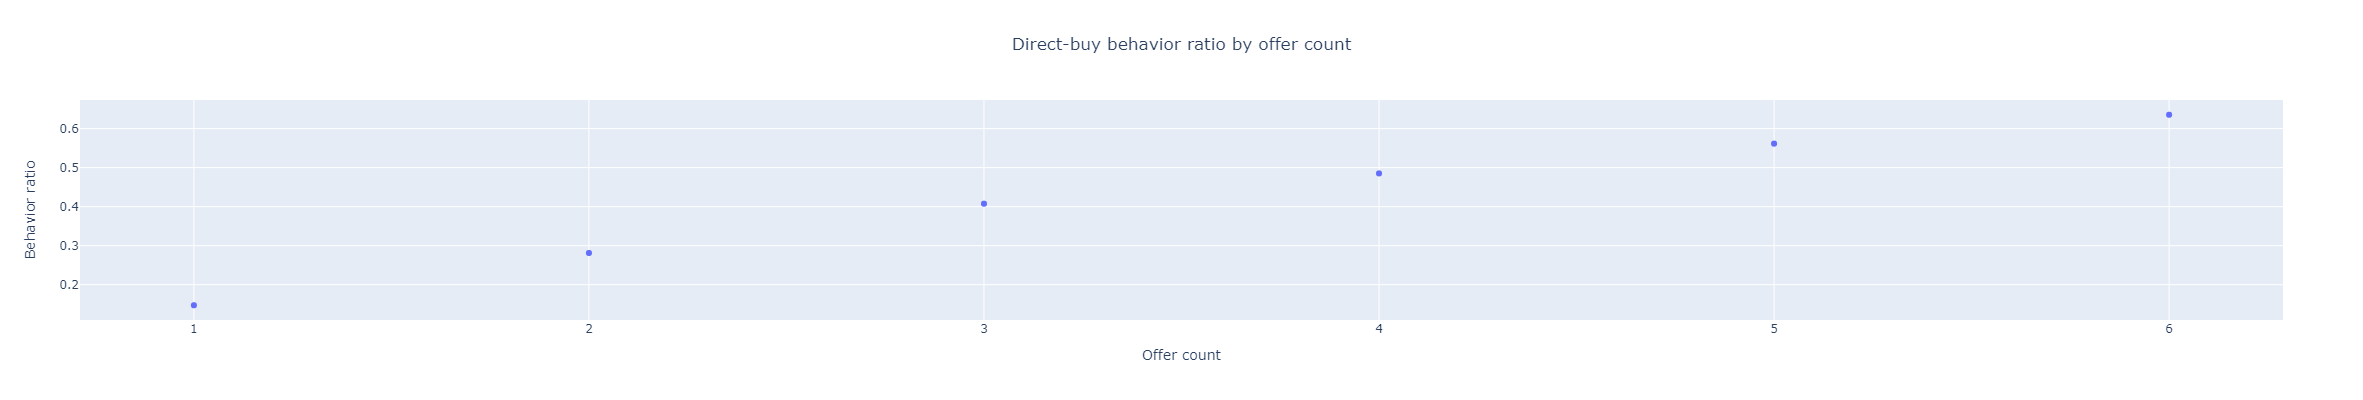

time: 47 ms (started: 2021-10-25 15:49:52 +08:00)


In [68]:
tmp = df_buy_model.groupby(['offer_count']).agg({'target':np.mean})
fig = px.scatter(x=tmp.index, 
                 y=tmp.target,
                 labels={'x':'Offer count', 'y':'Behavior ratio'},
                 title="Direct-buy behavior ratio by offer count",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show(config=config)

In [69]:
df_buy_model['offer_count'].value_counts()

4.0    4561
3.0    4164
5.0    2748
2.0    2059
6.0     675
1.0     557
Name: offer_count, dtype: int64

time: 0 ns (started: 2021-10-25 15:49:53 +08:00)


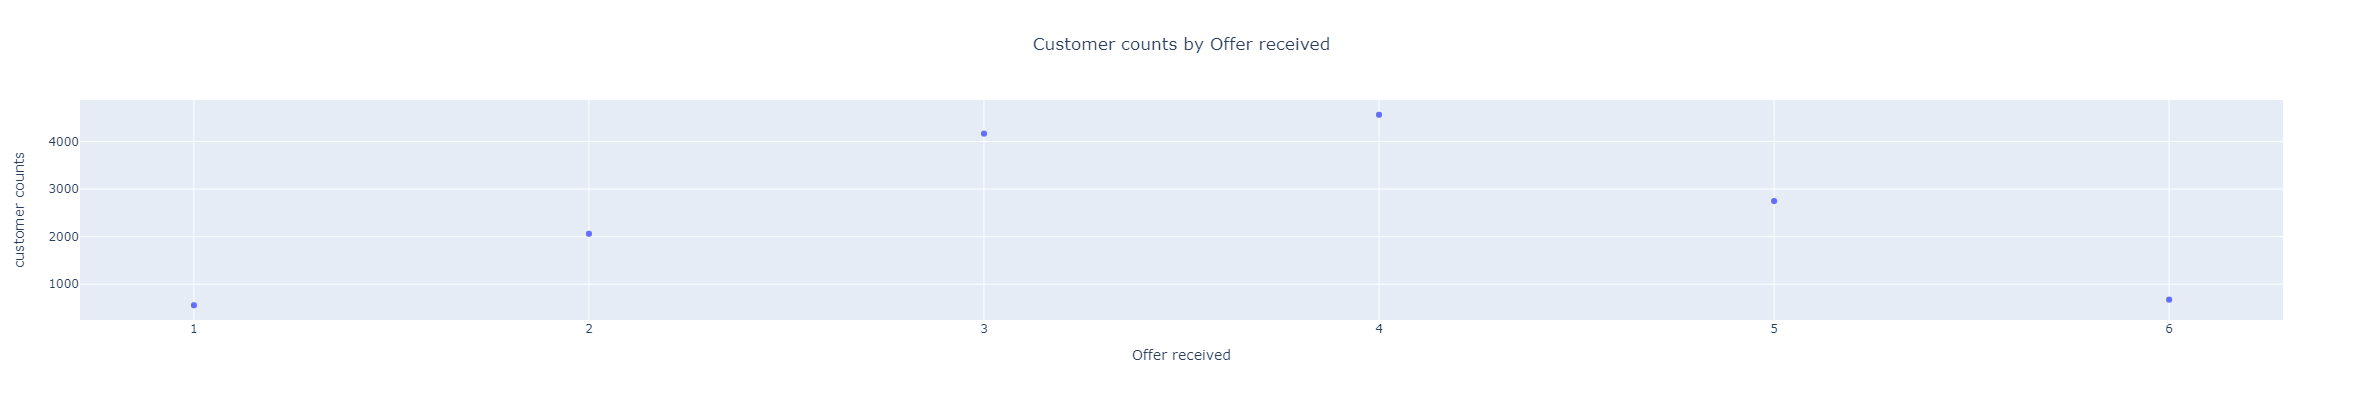

time: 31 ms (started: 2021-10-25 15:49:53 +08:00)


In [70]:
tmp = df_buy_model['offer_count'].value_counts()
fig = px.scatter(x=tmp.index, 
                 y=tmp.values,
                 labels={'x':'Offer received', 'y':'customer counts'},
                 title="Customer counts by Offer received",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show(config=config)

In [71]:
 df_buy_model['offer_count'].value_counts()

4.0    4561
3.0    4164
5.0    2748
2.0    2059
6.0     675
1.0     557
Name: offer_count, dtype: int64

time: 0 ns (started: 2021-10-25 15:49:53 +08:00)


The more offer send to a customer, the more he or she would act direct-buy behavior.

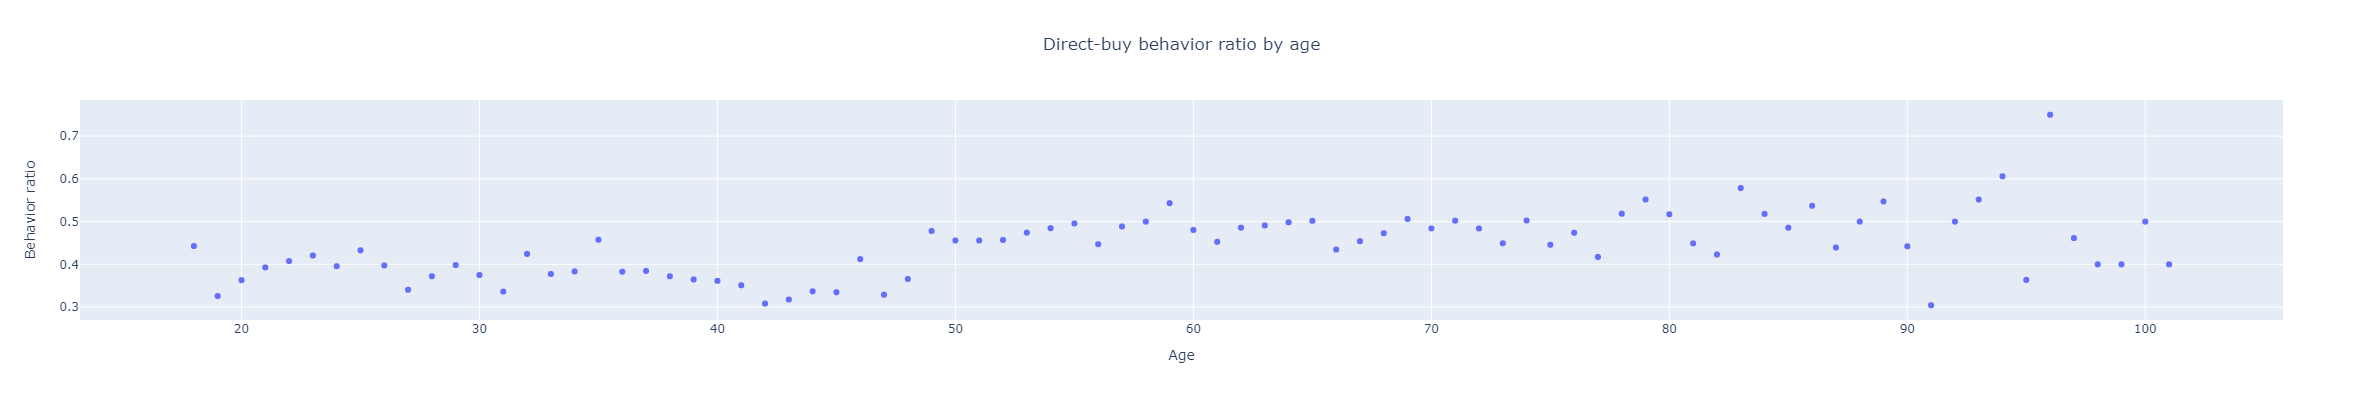

time: 32 ms (started: 2021-10-25 15:49:53 +08:00)


In [72]:
tmp = df_buy_model.groupby(['age']).agg({'target':np.mean})
fig = px.scatter(x=tmp.index, 
                 y=tmp.target,
                 labels={'x':'Age', 'y':'Behavior ratio'},
                 title="Direct-buy behavior ratio by age",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show(config=config)

customers of age between 20 and 50 are less likely to direct buy than that of age greater than 50.

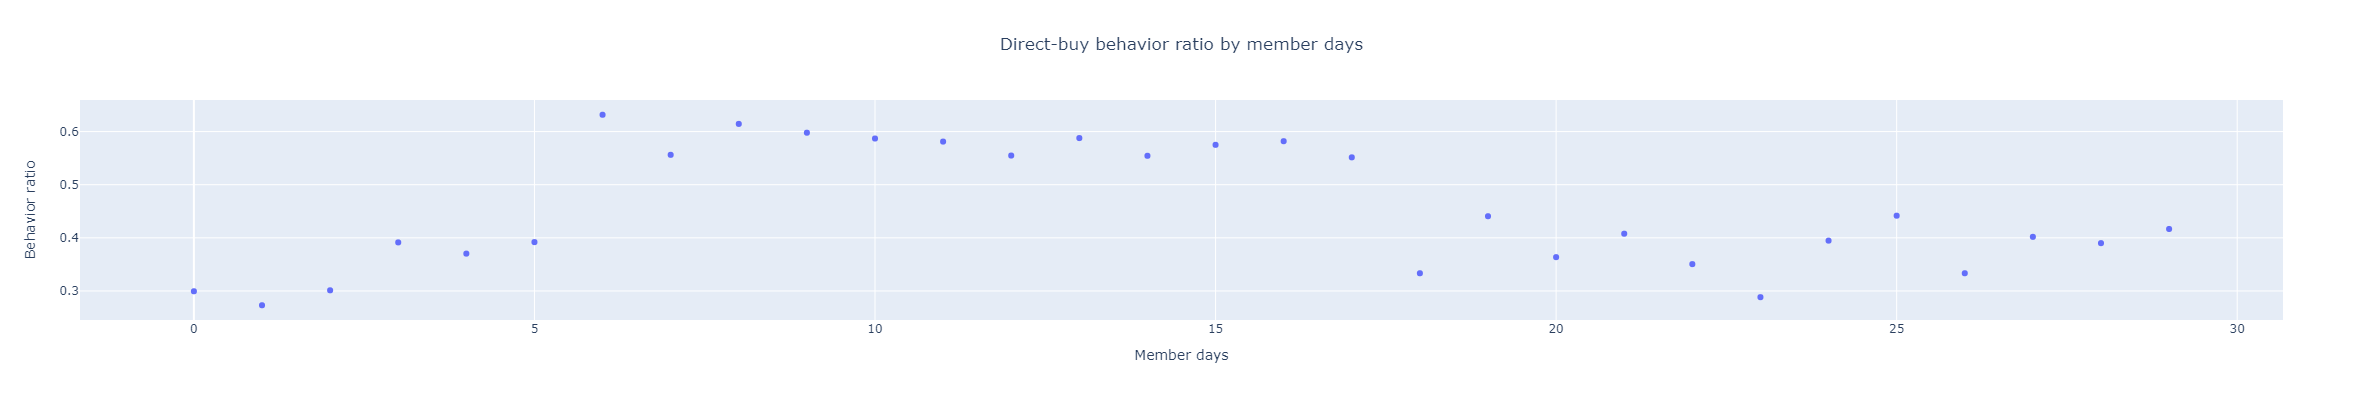

time: 32 ms (started: 2021-10-25 15:49:53 +08:00)


In [73]:
tmp = df_buy_model.groupby(['member_days_cut']).agg({'target':np.mean})
fig = px.scatter(x=tmp.index, 
                 y=tmp.target,
                 labels={'x':'Member days', 'y':'Behavior ratio'},
                 title="Direct-buy behavior ratio by member days",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show(config=config)

1 period=60 days. 5-17 periods (300-1020days) has a higher ratio of direct buy behavor.

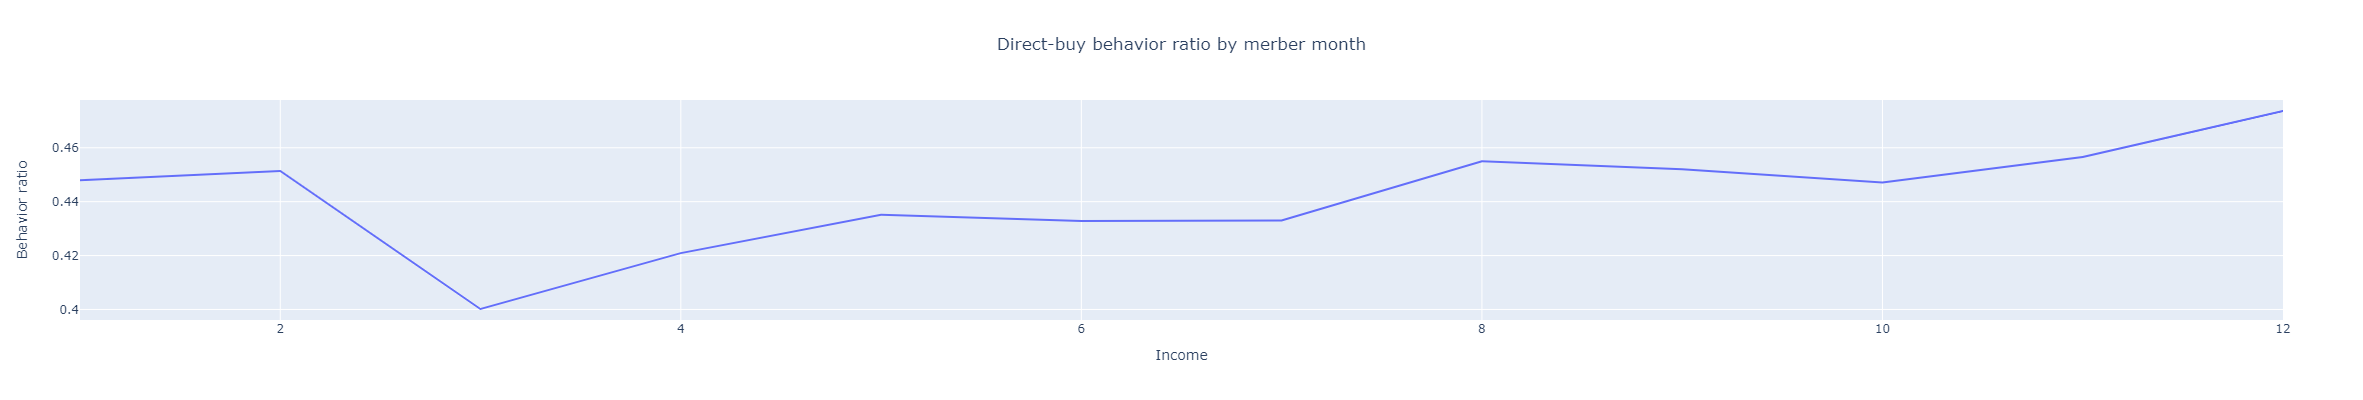

time: 47 ms (started: 2021-10-25 15:49:53 +08:00)


In [74]:
tmp = df_buy_model.groupby(['member_in_month']).agg({'target':np.mean})
fig = px.line(x=tmp.index, 
                 y=tmp.target,
                 labels={'x':'Income', 'y':'Behavior ratio'},
                 title="Direct-buy behavior ratio by merber month",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

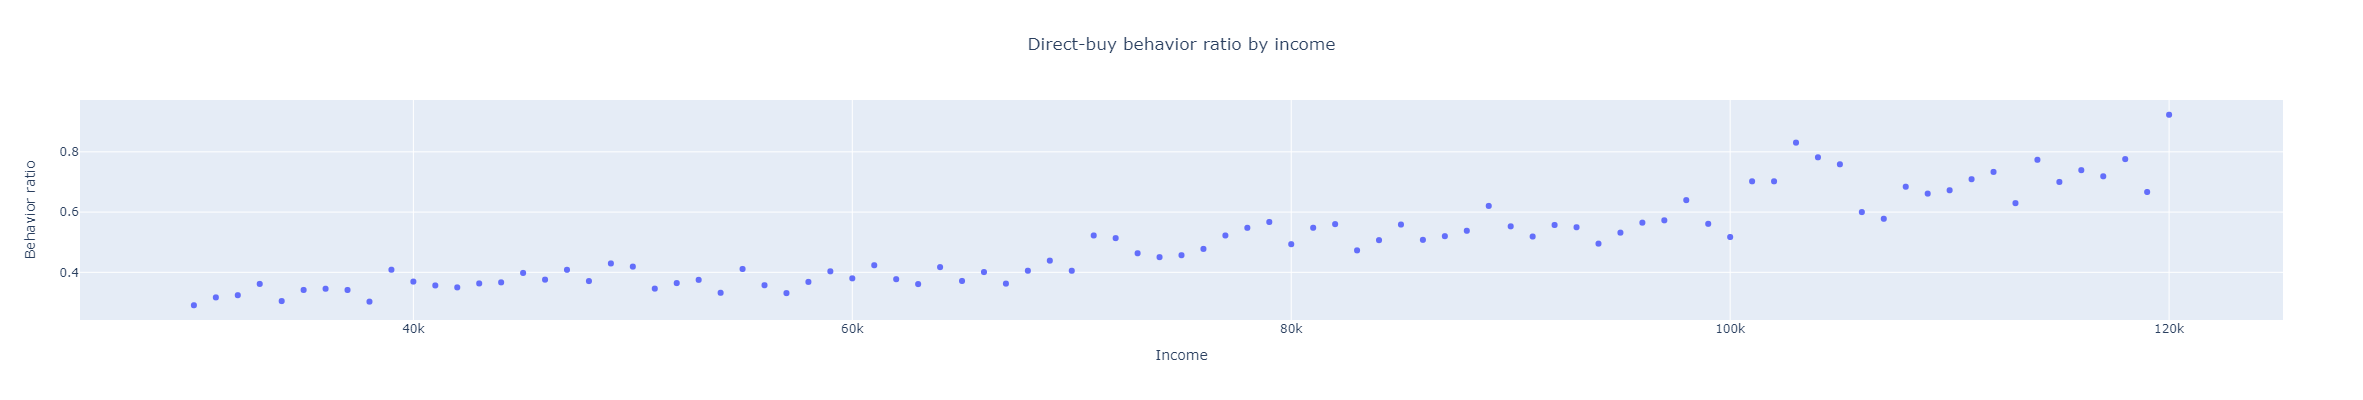

time: 31 ms (started: 2021-10-25 15:49:53 +08:00)


In [75]:
tmp = df_buy_model.groupby(['income']).agg({'target':np.mean})
fig = px.scatter(x=tmp.index, 
                 y=tmp.target,
                 labels={'x':'Income', 'y':'Behavior ratio'},
                 title="Direct-buy behavior ratio by income",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show(config=config)

Higher income lead to higher direct buy ratio.

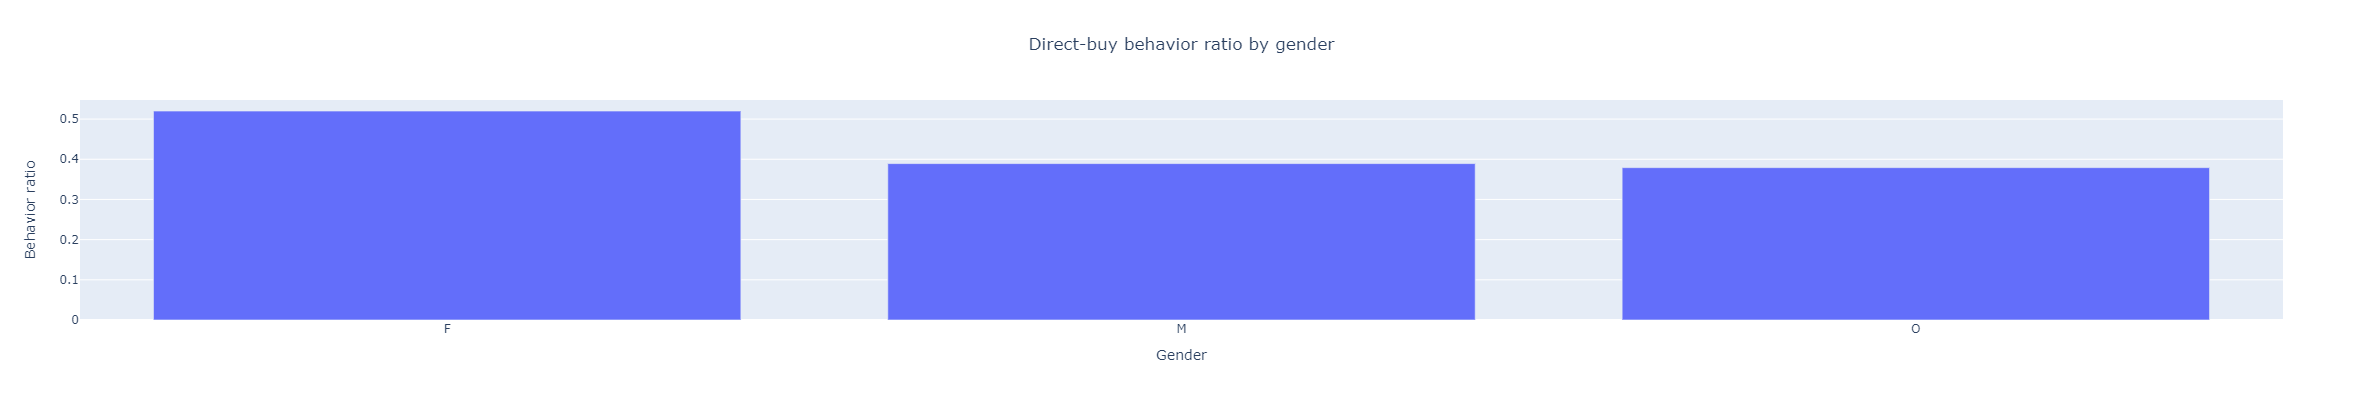

time: 46 ms (started: 2021-10-25 15:49:53 +08:00)


In [76]:
tmp = df_buy_model.groupby(['gender']).agg({'target':np.mean})
fig = px.bar(x=tmp.index, 
                 y=tmp.target,
                 labels={'x':'Gender', 'y':'Behavior ratio'},
                 title="Direct-buy behavior ratio by gender",
                 width=600, height=400
                )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show(config=config)

The female are more inclined to consume without much consideration.

## Model

In [77]:
X_buy_model = df_buy_model[['age', 'offer_count',
        'member_days_last','member_in_year','member_in_month','member_on_day',
       'gender_F', 'gender_M', 'gender_O',
        'income', 'income_cut']]

time: 0 ns (started: 2021-10-25 15:49:53 +08:00)


In [78]:
X_buy_model = X_buy_model.astype('int')

time: 0 ns (started: 2021-10-25 15:49:53 +08:00)


In [79]:
X_buy_model.shape

(14764, 11)

time: 0 ns (started: 2021-10-25 15:49:53 +08:00)


In [80]:
y_buy_model = df_buy_model['target']

time: 0 ns (started: 2021-10-25 15:49:53 +08:00)


In [81]:
y_buy_model.value_counts()

0    8221
1    6543
Name: target, dtype: int64

time: 0 ns (started: 2021-10-25 15:49:53 +08:00)


In [82]:
predict_model(X=X_buy_model,y=y_buy_model,metric='f1')

model      f1
5      CatBoost  0.5979
2      LightGBM  0.5889
1  RandomForest  0.5695
4    ExtraTrees  0.5566
0      Logistic  0.5548
3    KNeighbors  0.5510
6           SVC  0.5283

time: 1min 1s (started: 2021-10-25 15:49:53 +08:00)


The higher f1 score is 0.60, the model would be not bad to estimate whether a customer will act direct-buy behavior.

## Model Tuning

In [83]:
# tuning model with optuna
study_buy_model = optuna.create_study(direction="maximize")
study_buy_model.optimize(lambda trial:objective(trial,X_buy_model,y_buy_model,'f1'), n_trials=150)
print(study_buy_model.best_trial)

[I 2021-10-25 15:50:55,129] A new study created in memory with name: no-name-54728730-da48-4351-810b-fc750ba89c4b
[I 2021-10-25 15:50:55,270] Trial 0 finished with value: 0.5093203076755696 and parameters: {'classifier': 'Logistic', 'lr_c': 2546.371598692298}. Best is trial 0 with value: 0.5093203076755696.
[I 2021-10-25 15:50:55,430] Trial 1 finished with value: 0.5467838989529954 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3, 'rf_n_estimators': 29}. Best is trial 1 with value: 0.5467838989529954.
[I 2021-10-25 15:50:55,612] Trial 2 finished with value: 0.4986940975301435 and parameters: {'classifier': 'KNeighbors', 'kn_n_neighbors': 20}. Best is trial 1 with value: 0.5467838989529954.
[I 2021-10-25 15:50:55,997] Trial 3 finished with value: 0.5949588449574079 and parameters: {'classifier': 'CatBoost', 'iterations': 43}. Best is trial 3 with value: 0.5949588449574079.
[I 2021-10-25 15:50:56,116] Trial 4 finished with value: 0.5093203076755696 and parameters: {'class

FrozenTrial(number=69, values=[0.6028133115987762], datetime_start=datetime.datetime(2021, 10, 25, 15, 51, 18, 702017), datetime_complete=datetime.datetime(2021, 10, 25, 15, 51, 18, 855116), params={'classifier': 'LightGBM', 'lg_max_depth': 26, 'lg_num_leaves': 15}, distributions={'classifier': CategoricalDistribution(choices=('LightGBM', 'CatBoost', 'KNeighbors', 'Logistic', 'RandomForest')), 'lg_max_depth': IntLogUniformDistribution(high=100, low=2, step=1), 'lg_num_leaves': IntLogUniformDistribution(high=100, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=69, state=TrialState.COMPLETE, value=None)
time: 37 s (started: 2021-10-25 15:50:55 +08:00)


The best performance `optuna` shows is 0.6028133115987762, a modest improvement. And the params of that are `{'classifier': 'LightGBM', 'lg_max_depth': 26, 'lg_num_leaves': 15}`.

# Conclusion

This post analyzed a Starbucks promotion experiment from a customer decision perspective. The promotion offer process is divided into view stage and engage stage. EDA and machine learning models were built to analyze and predict conversion rate in each stage and the f1 score estimators show a good result. And we also tried to find the attributes of direct-buy customers.This post reveals that there can be a trade-off between promotion and direct-buy behavior.